In [7]:
import sys
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/poc")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/dags")

#Import libs python
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import date

#Import libs internas
from utils import spark_utils_session as utils

from hooks.hdfs.hdfs_helper import HdfsHelper
from jobs.job_base_config import BaseETLJobClass

import poc_helper
poc_helper.load_env("PROD")

'.env_file' loaded!
ENV 'PROD' configured!


In [8]:
def get_session(profile: str, dynamic_allocation_enabled: bool = True) -> utils.DBASparkAppSession:
    """Generates DBASparkAppSession."""
    
    app_name = "tsevero_argos"
    
    spark_builder = (utils.DBASparkAppSession
                     .builder
                     .setAppName(app_name)
                     .usingProcessProfile(profile)
                    )
    
    if dynamic_allocation_enabled:
        spark_builder.autoResourceManagement()

    return spark_builder.build()

session = get_session(profile='efd_t2')

2025-10-03T18:13:01.853188Z [info     ] Using json file settings.      [root] loc=spark_utils_session.py:301
2025-10-03T18:13:01.854706Z [info     ] Exporting default ENV.         [root] loc=spark_utils_session.py:305
2025-10-03T18:13:01.855130Z [info     ] Exporting custom ENVs.         [root] loc=spark_utils_session.py:338
2025-10-03T18:13:01.855590Z [info     ] Building profile 'efd_t2'.     [root] loc=spark_utils_session.py:221
2025-10-03T18:13:01.855950Z [info     ] Not enough info for building the kerberos client. Ignoring it [root] loc=spark_utils_session.py:284


:: loading settings :: url = jar:file:/opt/cloudera/parcels/SPARK3-3.5.4.3.5.7191000.0-30-1.p0.68499982/lib/spark3/jars/ivy-2.5.2.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/tsevero/.ivy2/cache
The jars for the packages stored in: /home/tsevero/.ivy2/jars
com.databricks#spark-xml_2.12 added as a dependency
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
com.oracle.database.security#oraclepki added as a dependency
com.oracle.database.security#osdt_core added as a dependency
com.oracle.database.security#osdt_cert added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-49d0b651-d15a-4de7-85cb-9a7d6aab38bf;1.0
	confs: [default]
	found com.databricks#spark-xml_2.12;0.18.0 in central
	found commons-io#commons-io;2.11.0 in central
	found org.glassfish.jaxb#txw2;3.0.2 in central
	found org.apache.ws.xmlschema#xmlschema-core;2.3.0 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.9.0 in central
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.9.2 in central
	found com.oracle.database.security#oraclepki;21.18.0.0 in central
	found com.oracle.databa

In [9]:
session.sparkSession.sql("SHOW DATABASES").show(truncate=False)

Hive Session ID = b27eb595-2197-4a8c-8d6f-e7cdd460edb8


+------------------+
|namespace         |
+------------------+
|anac              |
|bcadastro         |
|bpe               |
|c115              |
|ccc               |
|ccg               |
|cte               |
|default           |
|destda            |
|detran_share      |
|dime              |
|due               |
|efd               |
|fci               |
|gecob             |
|gescol            |
|gessimples        |
|gplam             |
|information_schema|
|malhas            |
+------------------+
only showing top 20 rows



In [10]:
from datetime import date, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configurações visuais
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

# Acesso ao SparkSession
spark = session.sparkSession

print("=" * 80)
print("SISTEMA ARGOS - ANÁLISE DE MUDANÇA DE COMPORTAMENTO TRIBUTÁRIO")
print("=" * 80)
print(f"Iniciado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

print(f"✅ Sessão Spark criada: {spark.sparkContext.appName}")
print(f"   Versão Spark: {spark.version}")
print(f"   Spark UI: {spark.sparkContext.uiWebUrl}")

SISTEMA ARGOS - ANÁLISE DE MUDANÇA DE COMPORTAMENTO TRIBUTÁRIO
Iniciado em: 2025-10-03 15:13:47
✅ Sessão Spark criada: tsevero_argos
   Versão Spark: 3.5.4.3.5.7191000.0-30
   Spark UI: None


In [11]:
print("=" * 80)
print("CARREGAMENTO E VERIFICAÇÃO DOS DADOS")
print("=" * 80)

# Carregar dados principais
query_principal = """
SELECT 
    periodo,
    cnpj_emitente,
    nm_razao_social,
    gtin,
    ncm,
    descricao,
    aliq_emitente_periodo,
    aliq_emitente_media_historica,
    aliquota_ia,
    bc_total_periodo,
    diferenca_vs_ia_periodo,
    diferenca_vs_ia_historica,
    classificacao_mudanca,
    movimento_vs_ia,
    YEAR(to_date(periodo, 'yyyyMM')) as ano,
    MONTH(to_date(periodo, 'yyyyMM')) as mes
FROM niat.argos_mudanca_comportamento
WHERE periodo >= '202301'
"""

df_argos = spark.sql(query_principal)
df_argos.cache()

total_registros = df_argos.count()
print(f"\n✅ Dados carregados: {total_registros:,} registros")

# Estatísticas básicas
print("\n📊 ESTATÍSTICAS BÁSICAS:")
stats = df_argos.agg(
    countDistinct("cnpj_emitente").alias("empresas"),
    countDistinct("periodo").alias("periodos"),
    countDistinct(concat_ws("-", col("gtin"), col("ncm"))).alias("produtos"),
    sum("bc_total_periodo").alias("bc_total"),
    avg("diferenca_vs_ia_periodo").alias("diff_ia_media")
).collect()[0]

print(f"  • Empresas monitoradas: {stats['empresas']:,}")
print(f"  • Períodos analisados: {stats['periodos']}")
print(f"  • Produtos distintos: {stats['produtos']:,}")
print(f"  • Base de Cálculo Total: R$ {float(stats['bc_total']):,.2f}")
print(f"  • Diferença média vs IA: {float(stats['diff_ia_media'])*100:.2f}%")

# Criar view para uso nas próximas análises
df_argos.createOrReplaceTempView("dados_argos")
print("\n✅ View 'dados_argos' criada para análises subsequentes")

CARREGAMENTO E VERIFICAÇÃO DOS DADOS



✅ Dados carregados: 5,252,190 registros

📊 ESTATÍSTICAS BÁSICAS:


[Stage 6:=============================>                             (1 + 1) / 2]

  • Empresas monitoradas: 28
  • Períodos analisados: 34
  • Produtos distintos: 118,075
  • Base de Cálculo Total: R$ 4,345,999,685.01
  • Diferença média vs IA: -1498.63%

✅ View 'dados_argos' criada para análises subsequentes


1. ANÁLISE DE DISTRIBUIÇÃO POR CLASSIFICAÇÃO DE MUDANÇA



DISTRIBUIÇÃO POR CLASSIFICAÇÃO:
  • PRODUTO_ESTAVEL          :  4,128,625 ( 78.6%)
    Empresas: 28 | BC: R$ 2,693,336,077.12
  • COMPORTAMENTO_NORMAL     :    939,281 ( 17.9%)
    Empresas: 28 | BC: R$ 1,507,130,708.93
  • MUDANCA_SIGNIFICATIVA    :    136,089 (  2.6%)
    Empresas: 28 | BC: R$ 77,549,474.91
  • MUDANCA_EXTREMA          :     48,195 (  0.9%)
    Empresas: 27 | BC: R$ 67,983,424.05


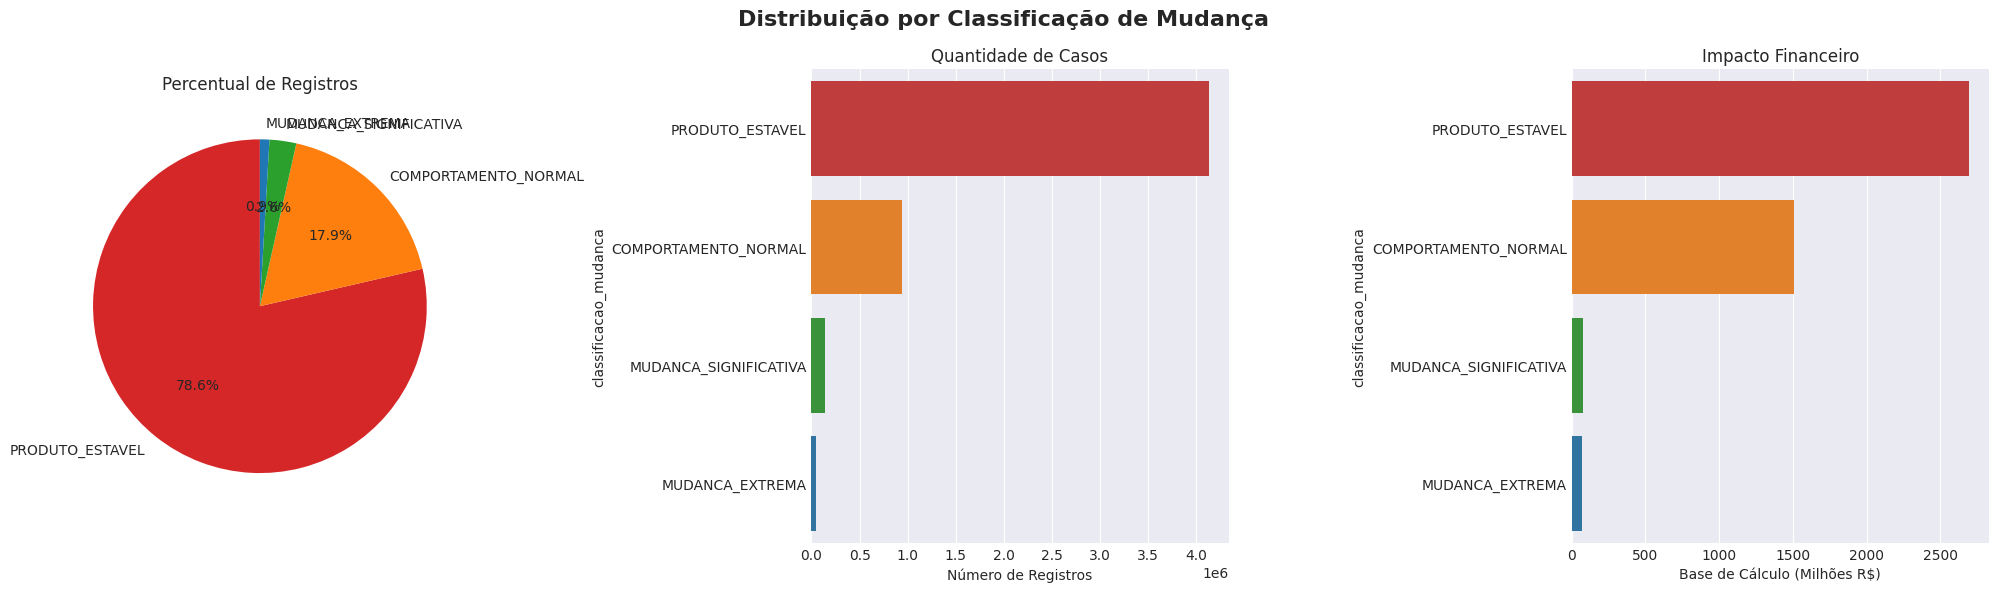

In [12]:
print("=" * 80)
print("1. ANÁLISE DE DISTRIBUIÇÃO POR CLASSIFICAÇÃO DE MUDANÇA")
print("=" * 80)

# Query de distribuição
dist_classificacao = spark.sql("""
SELECT 
    classificacao_mudanca,
    COUNT(*) as quantidade,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentual,
    COUNT(DISTINCT cnpj_emitente) as empresas,
    SUM(bc_total_periodo) as bc_total,
    AVG(diferenca_vs_ia_periodo) as diff_ia_media
FROM dados_argos
GROUP BY classificacao_mudanca
ORDER BY quantidade DESC
""")

dist_class_pd = dist_classificacao.toPandas()
dist_class_pd['bc_total'] = dist_class_pd['bc_total'].astype(float)

# Exibir tabela
print("\nDISTRIBUIÇÃO POR CLASSIFICAÇÃO:")
for _, row in dist_class_pd.iterrows():
    print(f"  • {row['classificacao_mudanca']:<25}: {row['quantidade']:>10,} ({row['percentual']:>5.1f}%)")
    print(f"    Empresas: {row['empresas']:,} | BC: R$ {row['bc_total']:,.2f}")

# Visualização
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribuição por Classificação de Mudança', fontsize=16, fontweight='bold')

# Gráfico 1: Pizza - Percentual
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
axes[0].pie(dist_class_pd['quantidade'], labels=dist_class_pd['classificacao_mudanca'], 
            autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Percentual de Registros')

# Gráfico 2: Barras - Quantidade
sns.barplot(data=dist_class_pd, y='classificacao_mudanca', x='quantidade', 
            ax=axes[1], palette=colors, orient='h')
axes[1].set_title('Quantidade de Casos')
axes[1].set_xlabel('Número de Registros')

# Gráfico 3: Barras - Impacto Financeiro
sns.barplot(data=dist_class_pd, y='classificacao_mudanca', x=dist_class_pd['bc_total']/1e6, 
            ax=axes[2], palette=colors, orient='h')
axes[2].set_title('Impacto Financeiro')
axes[2].set_xlabel('Base de Cálculo (Milhões R$)')

plt.tight_layout()
plt.show()

2. ANÁLISE DE MOVIMENTO vs ALÍQUOTA CORRETA (IA)



DISTRIBUIÇÃO POR MOVIMENTO:
  • APROXIMOU_DA_CORRETA     :    643,700 ( 14.1%)
    Empresas: 28 | BC: R$ 1,251,809,718.75
  • MANTEVE_DISTANCIA        :  3,573,568 ( 78.5%)
    Empresas: 28 | BC: R$ 2,434,211,133.60
  • AFASTOU_DA_CORRETA       :    336,499 (  7.4%)
    Empresas: 28 | BC: R$ 319,369,246.41


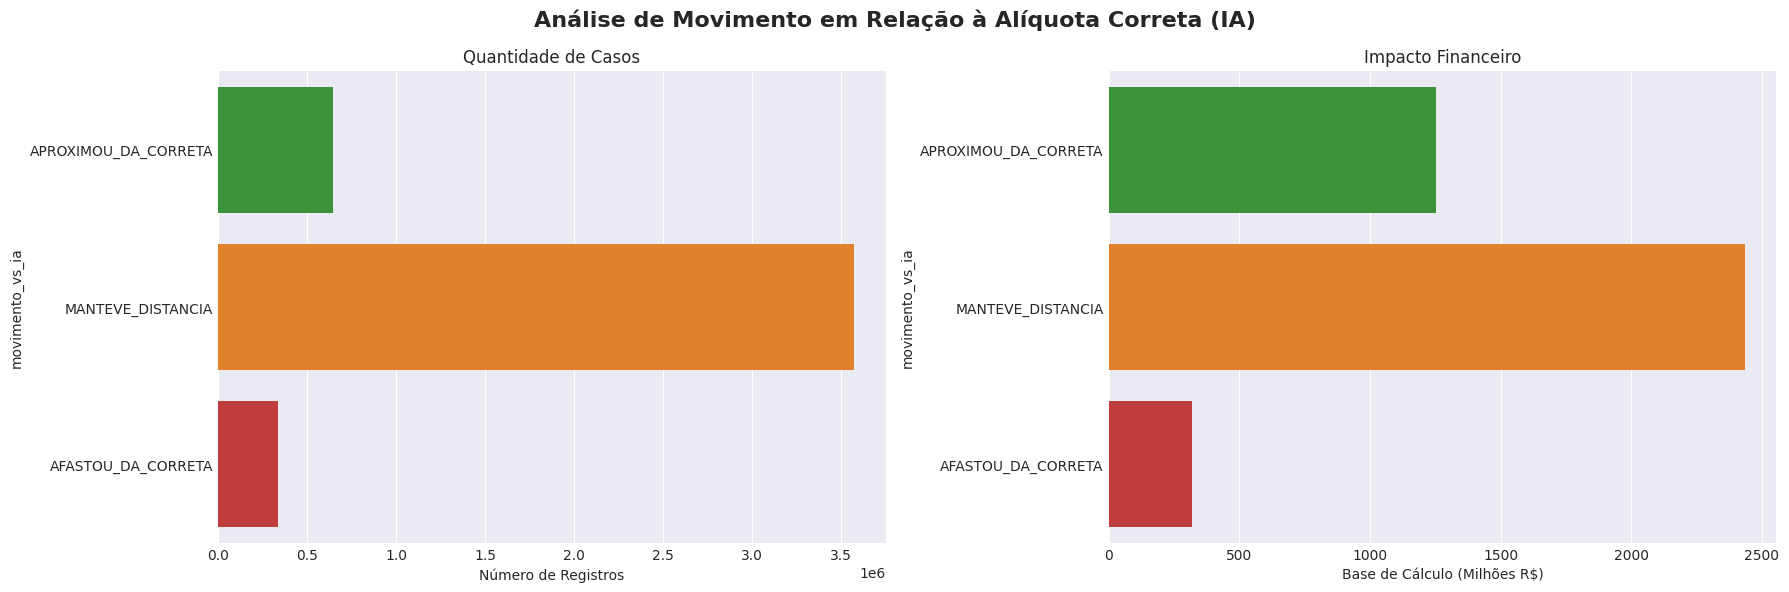


🎯 TAXA DE CORREÇÃO GERAL: 14.1%


In [13]:
print("=" * 80)
print("2. ANÁLISE DE MOVIMENTO vs ALÍQUOTA CORRETA (IA)")
print("=" * 80)

# Query de movimento
dist_movimento = spark.sql("""
SELECT 
    movimento_vs_ia,
    COUNT(*) as quantidade,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as percentual,
    COUNT(DISTINCT cnpj_emitente) as empresas,
    SUM(bc_total_periodo) as bc_total
FROM dados_argos
WHERE movimento_vs_ia != 'SEM_REFERENCIA_IA'
GROUP BY movimento_vs_ia
ORDER BY 
    CASE 
        WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' THEN 1
        WHEN movimento_vs_ia = 'MANTEVE_DISTANCIA' THEN 2
        ELSE 3
    END
""")

dist_mov_pd = dist_movimento.toPandas()
dist_mov_pd['bc_total'] = dist_mov_pd['bc_total'].astype(float)

# Exibir dados
print("\nDISTRIBUIÇÃO POR MOVIMENTO:")
for _, row in dist_mov_pd.iterrows():
    print(f"  • {row['movimento_vs_ia']:<25}: {row['quantidade']:>10,} ({row['percentual']:>5.1f}%)")
    print(f"    Empresas: {row['empresas']:,} | BC: R$ {row['bc_total']:,.2f}")

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Análise de Movimento em Relação à Alíquota Correta (IA)', fontsize=16, fontweight='bold')

# Gráfico 1: Barras horizontais
colors_mov = {'APROXIMOU_DA_CORRETA': '#2ca02c', 
              'MANTEVE_DISTANCIA': '#ff7f0e', 
              'AFASTOU_DA_CORRETA': '#d62728'}
palette_mov = [colors_mov[x] for x in dist_mov_pd['movimento_vs_ia']]

sns.barplot(data=dist_mov_pd, y='movimento_vs_ia', x='quantidade', 
            ax=axes[0], palette=palette_mov, orient='h')
axes[0].set_title('Quantidade de Casos')
axes[0].set_xlabel('Número de Registros')

# Gráfico 2: Impacto financeiro
sns.barplot(data=dist_mov_pd, y='movimento_vs_ia', x=dist_mov_pd['bc_total']/1e6, 
            ax=axes[1], palette=palette_mov, orient='h')
axes[1].set_title('Impacto Financeiro')
axes[1].set_xlabel('Base de Cálculo (Milhões R$)')

plt.tight_layout()
plt.show()

# Taxa de Correção
taxa_correcao = dist_mov_pd[dist_mov_pd['movimento_vs_ia'] == 'APROXIMOU_DA_CORRETA']['percentual'].values[0]
print(f"\n🎯 TAXA DE CORREÇÃO GERAL: {taxa_correcao:.1f}%")

3. EVOLUÇÃO TEMPORAL DAS MUDANÇAS



EVOLUÇÃO DOS ÚLTIMOS 12 PERÍODOS:
  202411 (2024-11)
    Casos: 164,710 | Empresas: 26
    Extremas: 283 | Taxa Correção: 14.9%
  202412 (2024-12)
    Casos: 170,895 | Empresas: 26
    Extremas: 148 | Taxa Correção: 14.4%
  202501 (2025-01)
    Casos: 167,430 | Empresas: 26
    Extremas: 64 | Taxa Correção: 14.3%
  202502 (2025-02)
    Casos: 164,932 | Empresas: 26
    Extremas: 53 | Taxa Correção: 14.5%
  202503 (2025-03)
    Casos: 201,161 | Empresas: 28
    Extremas: 138 | Taxa Correção: 12.2%
  202504 (2025-04)
    Casos: 211,527 | Empresas: 28
    Extremas: 398 | Taxa Correção: 11.6%
  202505 (2025-05)
    Casos: 207,352 | Empresas: 28
    Extremas: 231 | Taxa Correção: 11.5%
  202506 (2025-06)
    Casos: 200,184 | Empresas: 26
    Extremas: 285 | Taxa Correção: 10.4%
  202507 (2025-07)
    Casos: 212,595 | Empresas: 26
    Extremas: 456 | Taxa Correção: 9.8%
  202508 (2025-08)
    Casos: 202,694 | Empresas: 26
    Extremas: 1477 | Taxa Correção: 10.5%
  202509 (2025-09)
    Caso

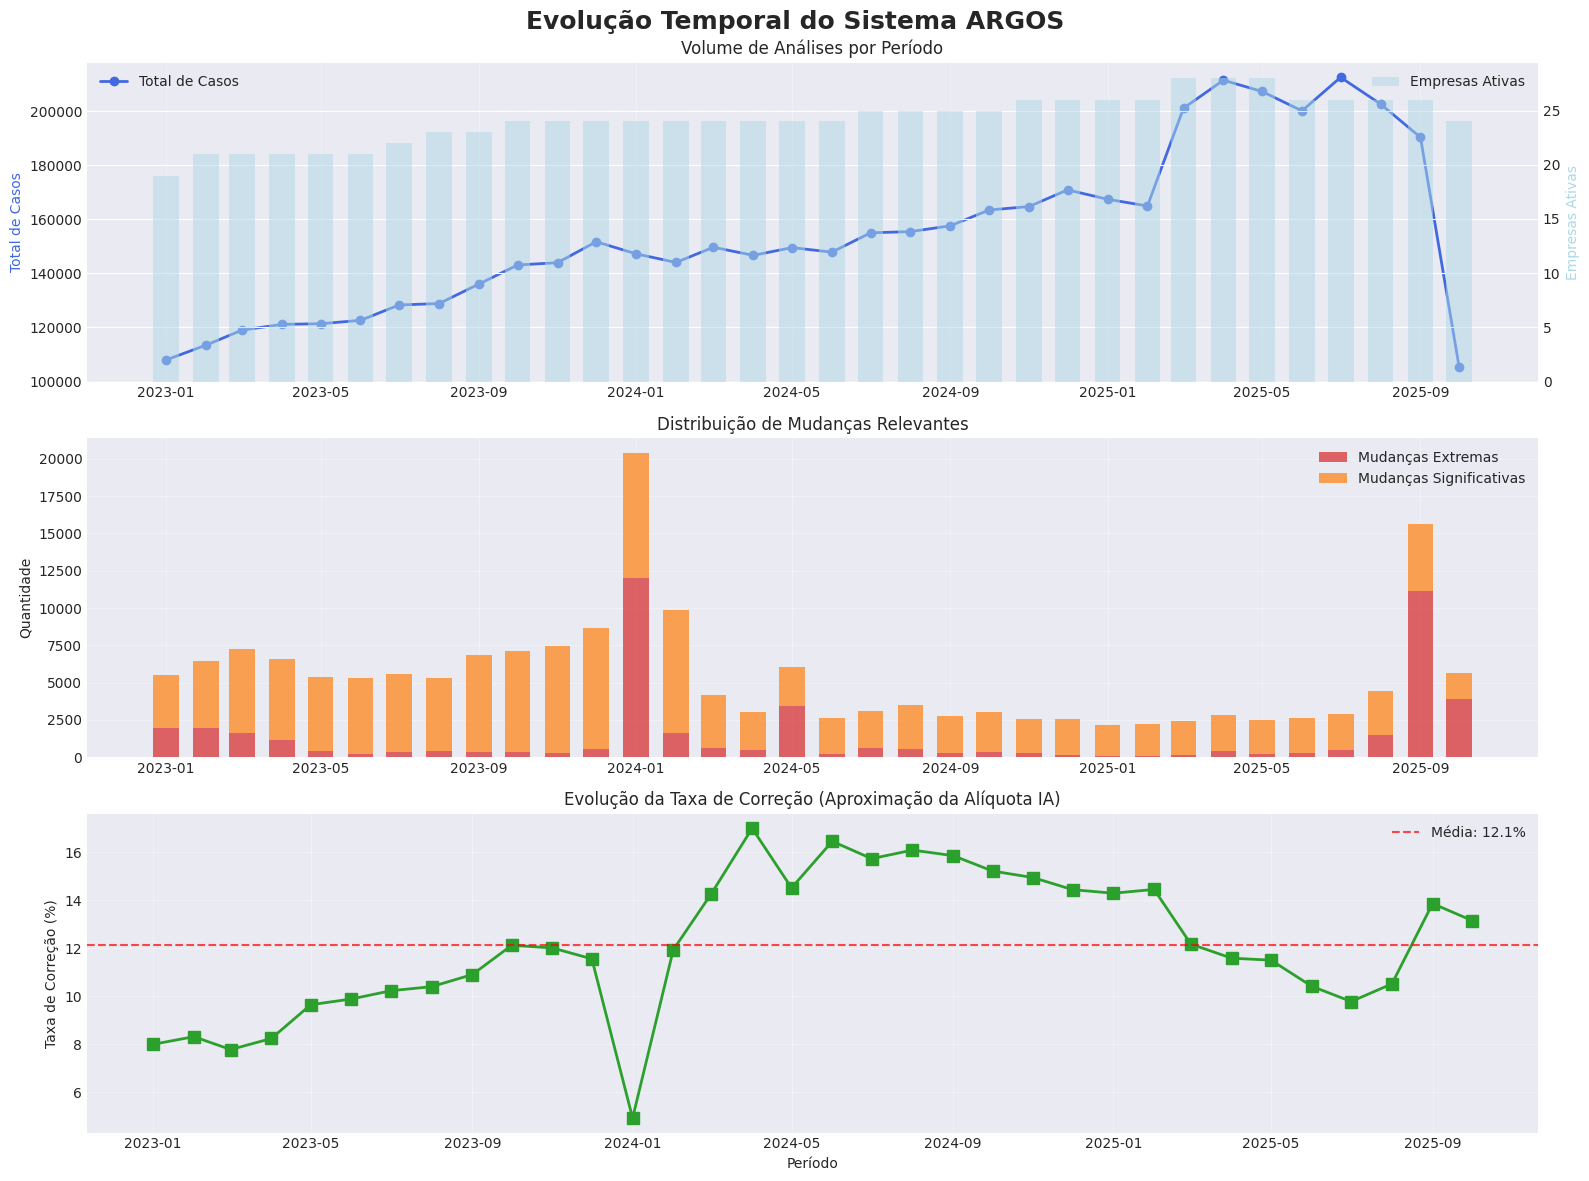

In [14]:
print("=" * 80)
print("3. EVOLUÇÃO TEMPORAL DAS MUDANÇAS")
print("=" * 80)

# Query temporal
evolucao = spark.sql("""
SELECT 
    periodo,
    to_date(periodo, 'yyyyMM') as periodo_dt,
    COUNT(*) as total_casos,
    COUNT(DISTINCT cnpj_emitente) as empresas_ativas,
    SUM(bc_total_periodo) as bc_total,
    SUM(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 1 ELSE 0 END) as mudancas_extremas,
    SUM(CASE WHEN classificacao_mudanca = 'MUDANCA_SIGNIFICATIVA' THEN 1 ELSE 0 END) as mudancas_significativas,
    SUM(CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' THEN 1 ELSE 0 END) as aproximou_ia,
    SUM(CASE WHEN movimento_vs_ia = 'AFASTOU_DA_CORRETA' THEN 1 ELSE 0 END) as afastou_ia,
    AVG(diferenca_vs_ia_periodo) as diff_ia_media
FROM dados_argos
GROUP BY periodo
ORDER BY periodo
""")

evolucao_pd = evolucao.toPandas()
evolucao_pd['bc_total'] = evolucao_pd['bc_total'].astype(float)
evolucao_pd['periodo_dt'] = pd.to_datetime(evolucao_pd['periodo_dt'])
evolucao_pd['taxa_correcao'] = (evolucao_pd['aproximou_ia'] / evolucao_pd['total_casos'] * 100)

# Exibir últimos 12 períodos
print("\nEVOLUÇÃO DOS ÚLTIMOS 12 PERÍODOS:")
for _, row in evolucao_pd.tail(12).iterrows():
    print(f"  {row['periodo']} ({row['periodo_dt'].strftime('%Y-%m')})")
    print(f"    Casos: {row['total_casos']:,} | Empresas: {row['empresas_ativas']:,}")
    print(f"    Extremas: {row['mudancas_extremas']} | Taxa Correção: {row['taxa_correcao']:.1f}%")

# Visualização
fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Evolução Temporal do Sistema ARGOS', fontsize=18, fontweight='bold')

# Gráfico 1: Total de casos e empresas
ax1 = axes[0]
ax1.plot(evolucao_pd['periodo_dt'], evolucao_pd['total_casos'], 
         marker='o', color='royalblue', linewidth=2, label='Total de Casos')
ax1_twin = ax1.twinx()
ax1_twin.bar(evolucao_pd['periodo_dt'], evolucao_pd['empresas_ativas'], 
             color='lightblue', alpha=0.5, width=20, label='Empresas Ativas')
ax1.set_ylabel('Total de Casos', color='royalblue')
ax1_twin.set_ylabel('Empresas Ativas', color='lightblue')
ax1.set_title('Volume de Análises por Período')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')

# Gráfico 2: Mudanças extremas e significativas
ax2 = axes[1]
ax2.bar(evolucao_pd['periodo_dt'], evolucao_pd['mudancas_extremas'], 
        color='#d62728', alpha=0.7, label='Mudanças Extremas', width=20)
ax2.bar(evolucao_pd['periodo_dt'], evolucao_pd['mudancas_significativas'], 
        bottom=evolucao_pd['mudancas_extremas'], color='#ff7f0e', 
        alpha=0.7, label='Mudanças Significativas', width=20)
ax2.set_ylabel('Quantidade')
ax2.set_title('Distribuição de Mudanças Relevantes')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Gráfico 3: Taxa de correção
ax3 = axes[2]
ax3.plot(evolucao_pd['periodo_dt'], evolucao_pd['taxa_correcao'], 
         marker='s', color='#2ca02c', linewidth=2, markersize=8)
ax3.axhline(y=evolucao_pd['taxa_correcao'].mean(), color='red', 
            linestyle='--', alpha=0.7, label=f'Média: {evolucao_pd["taxa_correcao"].mean():.1f}%')
ax3.set_ylabel('Taxa de Correção (%)')
ax3.set_xlabel('Período')
ax3.set_title('Evolução da Taxa de Correção (Aproximação da Alíquota IA)')
ax3.grid(True, alpha=0.3)
ax3.legend()

plt.tight_layout()
plt.show()

4. RANKING DE EMPRESAS POR MUDANÇAS EXTREMAS



TOP 20 EMPRESAS POR MUDANÇAS EXTREMAS:

 1. SDB COMERCIO DE ALIMENTOS LTDA
    CNPJ: 09477652004850
    Total de Casos: 381,374 | Produtos: 16,253
    Mudanças Extremas: 6015 (1.6%)
    Taxa de Correção: 33.9%
    Base de Cálculo: R$ 1,041,894,105.27

 2. RWR LOGISTICA E DISTRIBUICAO LTDA
    CNPJ: 83616185001910
    Total de Casos: 235,328 | Produtos: 12,170
    Mudanças Extremas: 5006 (2.1%)
    Taxa de Correção: 4.8%
    Base de Cálculo: R$ 258,022,337.53

 3. SDB COMERCIO DE ALIMENTOS LTDA
    CNPJ: 09477652004000
    Total de Casos: 289,275 | Produtos: 15,159
    Mudanças Extremas: 4768 (1.6%)
    Taxa de Correção: 30.7%
    Base de Cálculo: R$ 555,107,686.11

 4. SUPERMERCADOS SCHUTZE LTDA
    CNPJ: 86378866000156
    Total de Casos: 517,900 | Produtos: 32,958
    Mudanças Extremas: 3382 (0.7%)
    Taxa de Correção: 6.5%
    Base de Cálculo: R$ 214,947,462.26

 5. SDB COMERCIO DE ALIMENTOS LTDA
    CNPJ: 09477652002644
    Total de Casos: 336,023 | Produtos: 15,264
    Mudanças 

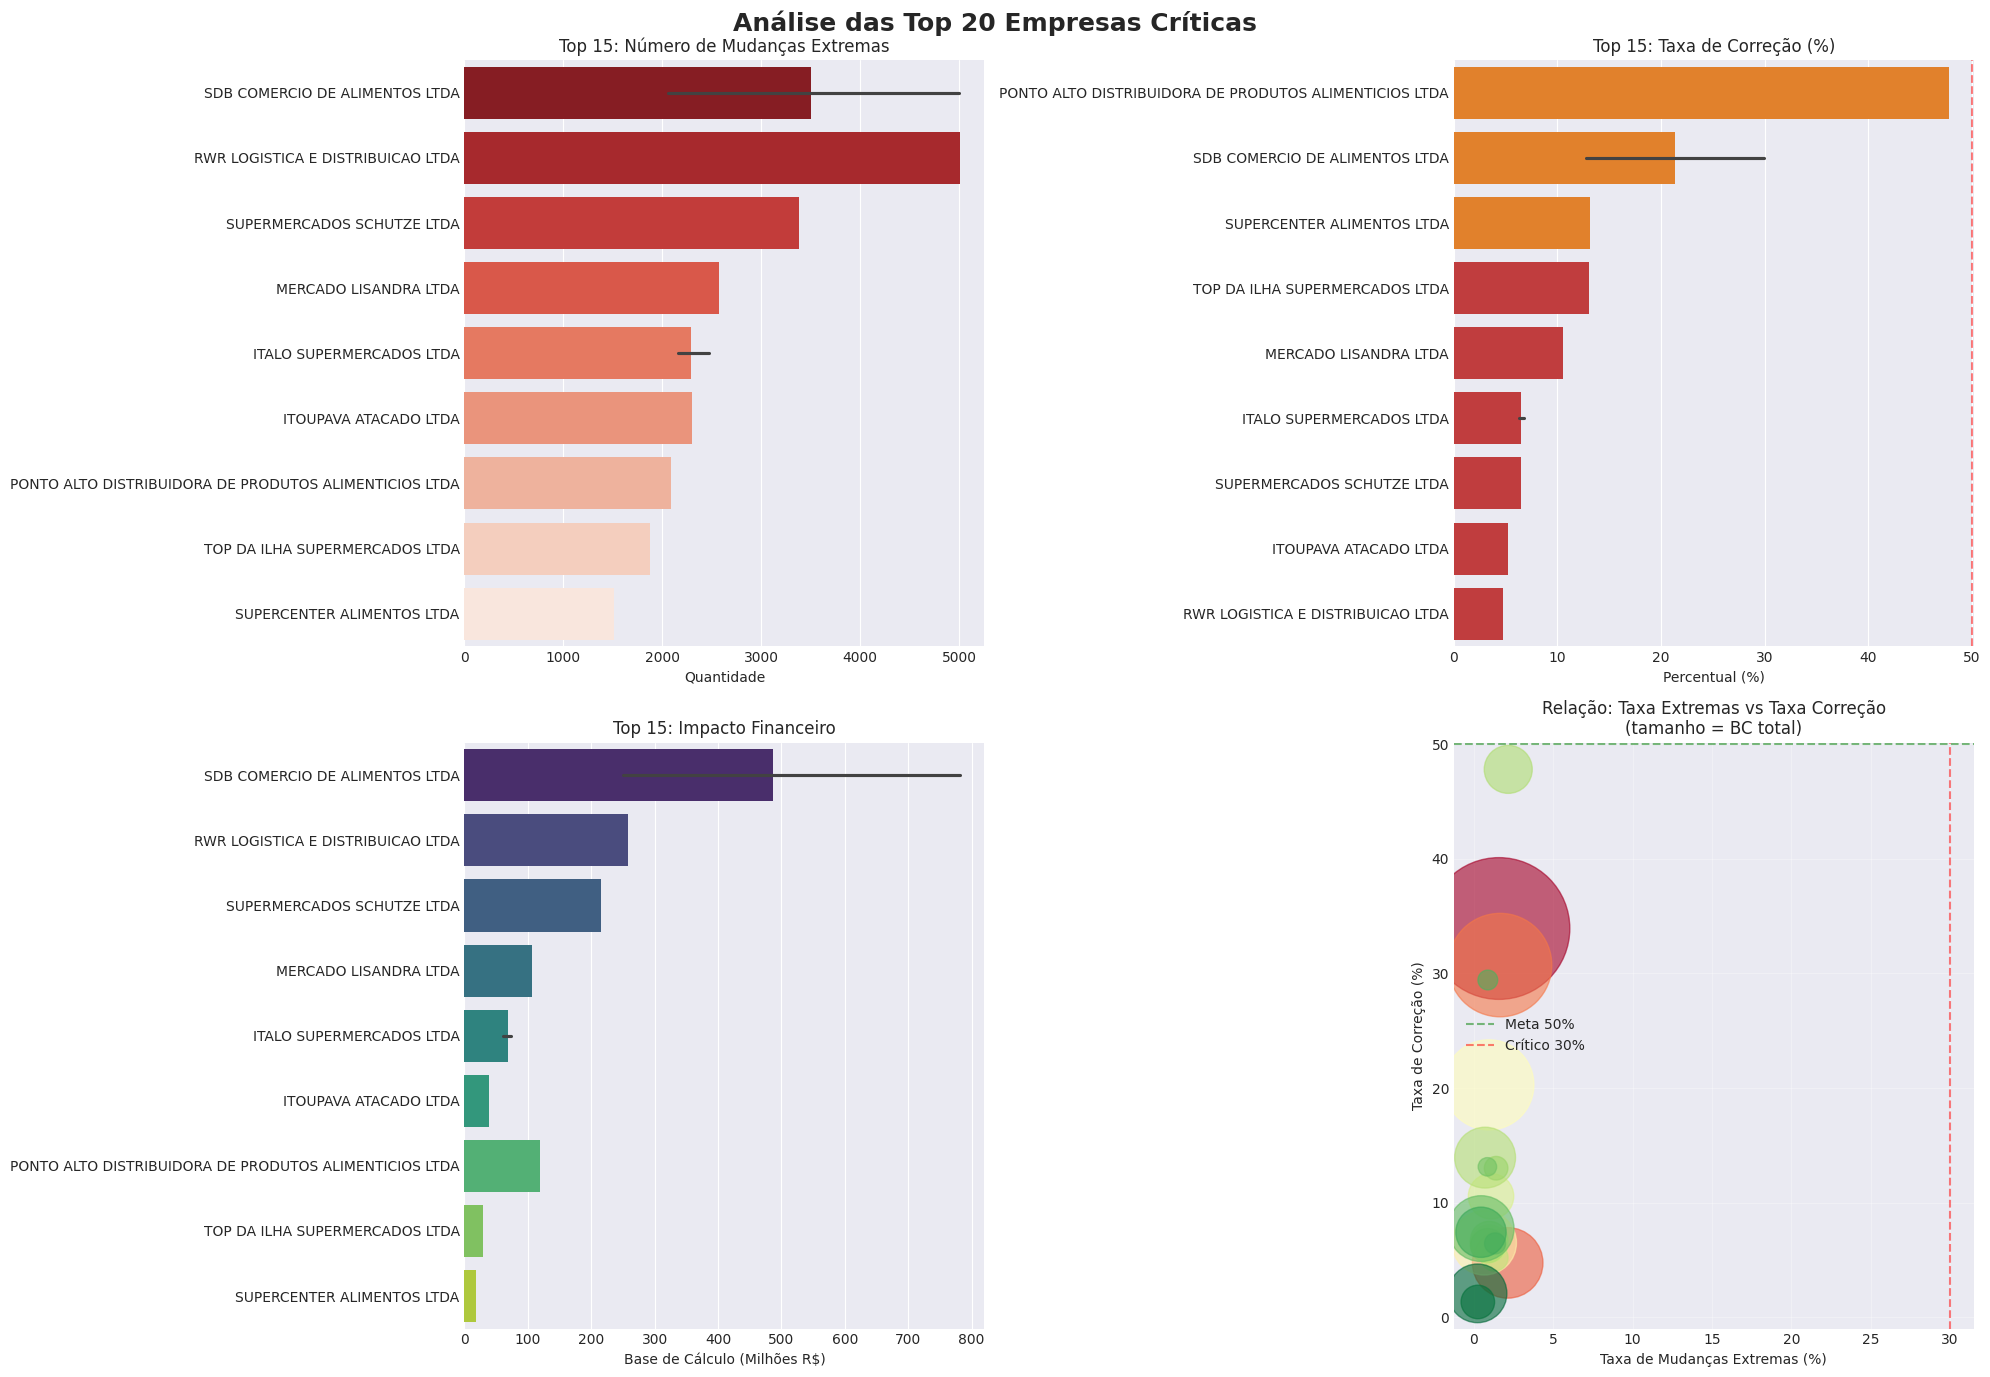

In [15]:
print("=" * 80)
print("4. RANKING DE EMPRESAS POR MUDANÇAS EXTREMAS")
print("=" * 80)

# Query de ranking
ranking_empresas = spark.sql("""
SELECT 
    cnpj_emitente,
    nm_razao_social,
    COUNT(*) as total_casos,
    COUNT(DISTINCT periodo) as periodos_ativos,
    COUNT(DISTINCT CONCAT(gtin, '-', ncm)) as produtos_distintos,
    SUM(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 1 ELSE 0 END) as mudancas_extremas,
    SUM(CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' THEN 1 ELSE 0 END) as aproximou_ia,
    SUM(CASE WHEN movimento_vs_ia = 'AFASTOU_DA_CORRETA' THEN 1 ELSE 0 END) as afastou_ia,
    SUM(bc_total_periodo) as bc_total,
    AVG(diferenca_vs_ia_periodo) as diff_ia_media
FROM dados_argos
GROUP BY cnpj_emitente, nm_razao_social
HAVING COUNT(*) >= 10
ORDER BY mudancas_extremas DESC, bc_total DESC
LIMIT 20
""")

ranking_pd = ranking_empresas.toPandas()
ranking_pd['bc_total'] = ranking_pd['bc_total'].astype(float)
ranking_pd['taxa_extremas'] = (ranking_pd['mudancas_extremas'] / ranking_pd['total_casos'] * 100)
ranking_pd['taxa_correcao'] = (ranking_pd['aproximou_ia'] / ranking_pd['total_casos'] * 100)

# Exibir ranking
print("\nTOP 20 EMPRESAS POR MUDANÇAS EXTREMAS:")
for i, row in ranking_pd.iterrows():
    print(f"\n{i+1:2d}. {row['nm_razao_social'][:50]}")
    print(f"    CNPJ: {row['cnpj_emitente']}")
    print(f"    Total de Casos: {row['total_casos']:,} | Produtos: {row['produtos_distintos']:,}")
    print(f"    Mudanças Extremas: {row['mudancas_extremas']} ({row['taxa_extremas']:.1f}%)")
    print(f"    Taxa de Correção: {row['taxa_correcao']:.1f}%")
    print(f"    Base de Cálculo: R$ {row['bc_total']:,.2f}")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Análise das Top 20 Empresas Críticas', fontsize=18, fontweight='bold')

# Gráfico 1: Mudanças extremas
sns.barplot(data=ranking_pd.head(15), y='nm_razao_social', x='mudancas_extremas', 
            ax=axes[0,0], palette='Reds_r', orient='h')
axes[0,0].set_title('Top 15: Número de Mudanças Extremas')
axes[0,0].set_xlabel('Quantidade')
axes[0,0].set_ylabel('')

# Gráfico 2: Taxa de correção
ranking_pd_sorted = ranking_pd.head(15).sort_values('taxa_correcao', ascending=False)
colors_correcao = ['#2ca02c' if x >= 50 else '#ff7f0e' if x >= 30 else '#d62728' 
                   for x in ranking_pd_sorted['taxa_correcao']]
sns.barplot(data=ranking_pd_sorted, y='nm_razao_social', x='taxa_correcao', 
            ax=axes[0,1], palette=colors_correcao, orient='h')
axes[0,1].set_title('Top 15: Taxa de Correção (%)')
axes[0,1].set_xlabel('Percentual (%)')
axes[0,1].set_ylabel('')
axes[0,1].axvline(x=50, color='red', linestyle='--', alpha=0.5)

# Gráfico 3: Base de cálculo
sns.barplot(data=ranking_pd.head(15), y='nm_razao_social', x=ranking_pd.head(15)['bc_total']/1e6, 
            ax=axes[1,0], palette='viridis', orient='h')
axes[1,0].set_title('Top 15: Impacto Financeiro')
axes[1,0].set_xlabel('Base de Cálculo (Milhões R$)')
axes[1,0].set_ylabel('')

# Gráfico 4: Scatter - Taxa extremas vs Taxa correção
scatter_data = ranking_pd.head(20)
axes[1,1].scatter(scatter_data['taxa_extremas'], scatter_data['taxa_correcao'], 
                  s=scatter_data['bc_total']/1e5, alpha=0.6, c=scatter_data['mudancas_extremas'], 
                  cmap='RdYlGn_r')
axes[1,1].set_xlabel('Taxa de Mudanças Extremas (%)')
axes[1,1].set_ylabel('Taxa de Correção (%)')
axes[1,1].set_title('Relação: Taxa Extremas vs Taxa Correção\n(tamanho = BC total)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axhline(y=50, color='green', linestyle='--', alpha=0.5, label='Meta 50%')
axes[1,1].axvline(x=30, color='red', linestyle='--', alpha=0.5, label='Crítico 30%')
axes[1,1].legend()

plt.tight_layout()
plt.show()

5. ANÁLISE SETORIAL POR NCM (2 DÍGITOS)



TOP 20 SETORES POR MUDANÇAS EXTREMAS:

Setor 19xx - Cereais
  Total: 756,411 casos | Empresas: 27 | Produtos: 17,973
  Extremas: 8516 (1.1%)
  Taxa Correção: 12.0%
  BC Total: R$ 532,425,275.32

Setor 21xx - Seção 21
  Total: 414,412 casos | Empresas: 27 | Produtos: 5,857
  Extremas: 4421 (1.1%)
  Taxa Correção: 13.8%
  BC Total: R$ 205,227,838.60

Setor 04xx - Laticínios
  Total: 275,022 casos | Empresas: 26 | Produtos: 3,842
  Extremas: 3781 (1.4%)
  Taxa Correção: 16.0%
  BC Total: R$ 482,667,315.13

Setor 33xx - Cosméticos
  Total: 433,525 casos | Empresas: 27 | Produtos: 6,393
  Extremas: 3743 (0.9%)
  Taxa Correção: 12.6%
  BC Total: R$ 155,823,512.74

Setor 22xx - Bebidas
  Total: 502,734 casos | Empresas: 27 | Produtos: 6,988
  Extremas: 3206 (0.6%)
  Taxa Correção: 11.2%
  BC Total: R$ 567,538,833.55

Setor 34xx - Seção 34
  Total: 373,942 casos | Empresas: 26 | Produtos: 5,829
  Extremas: 3076 (0.8%)
  Taxa Correção: 14.6%
  BC Total: R$ 196,038,476.16

Setor 02xx - Carnes
 

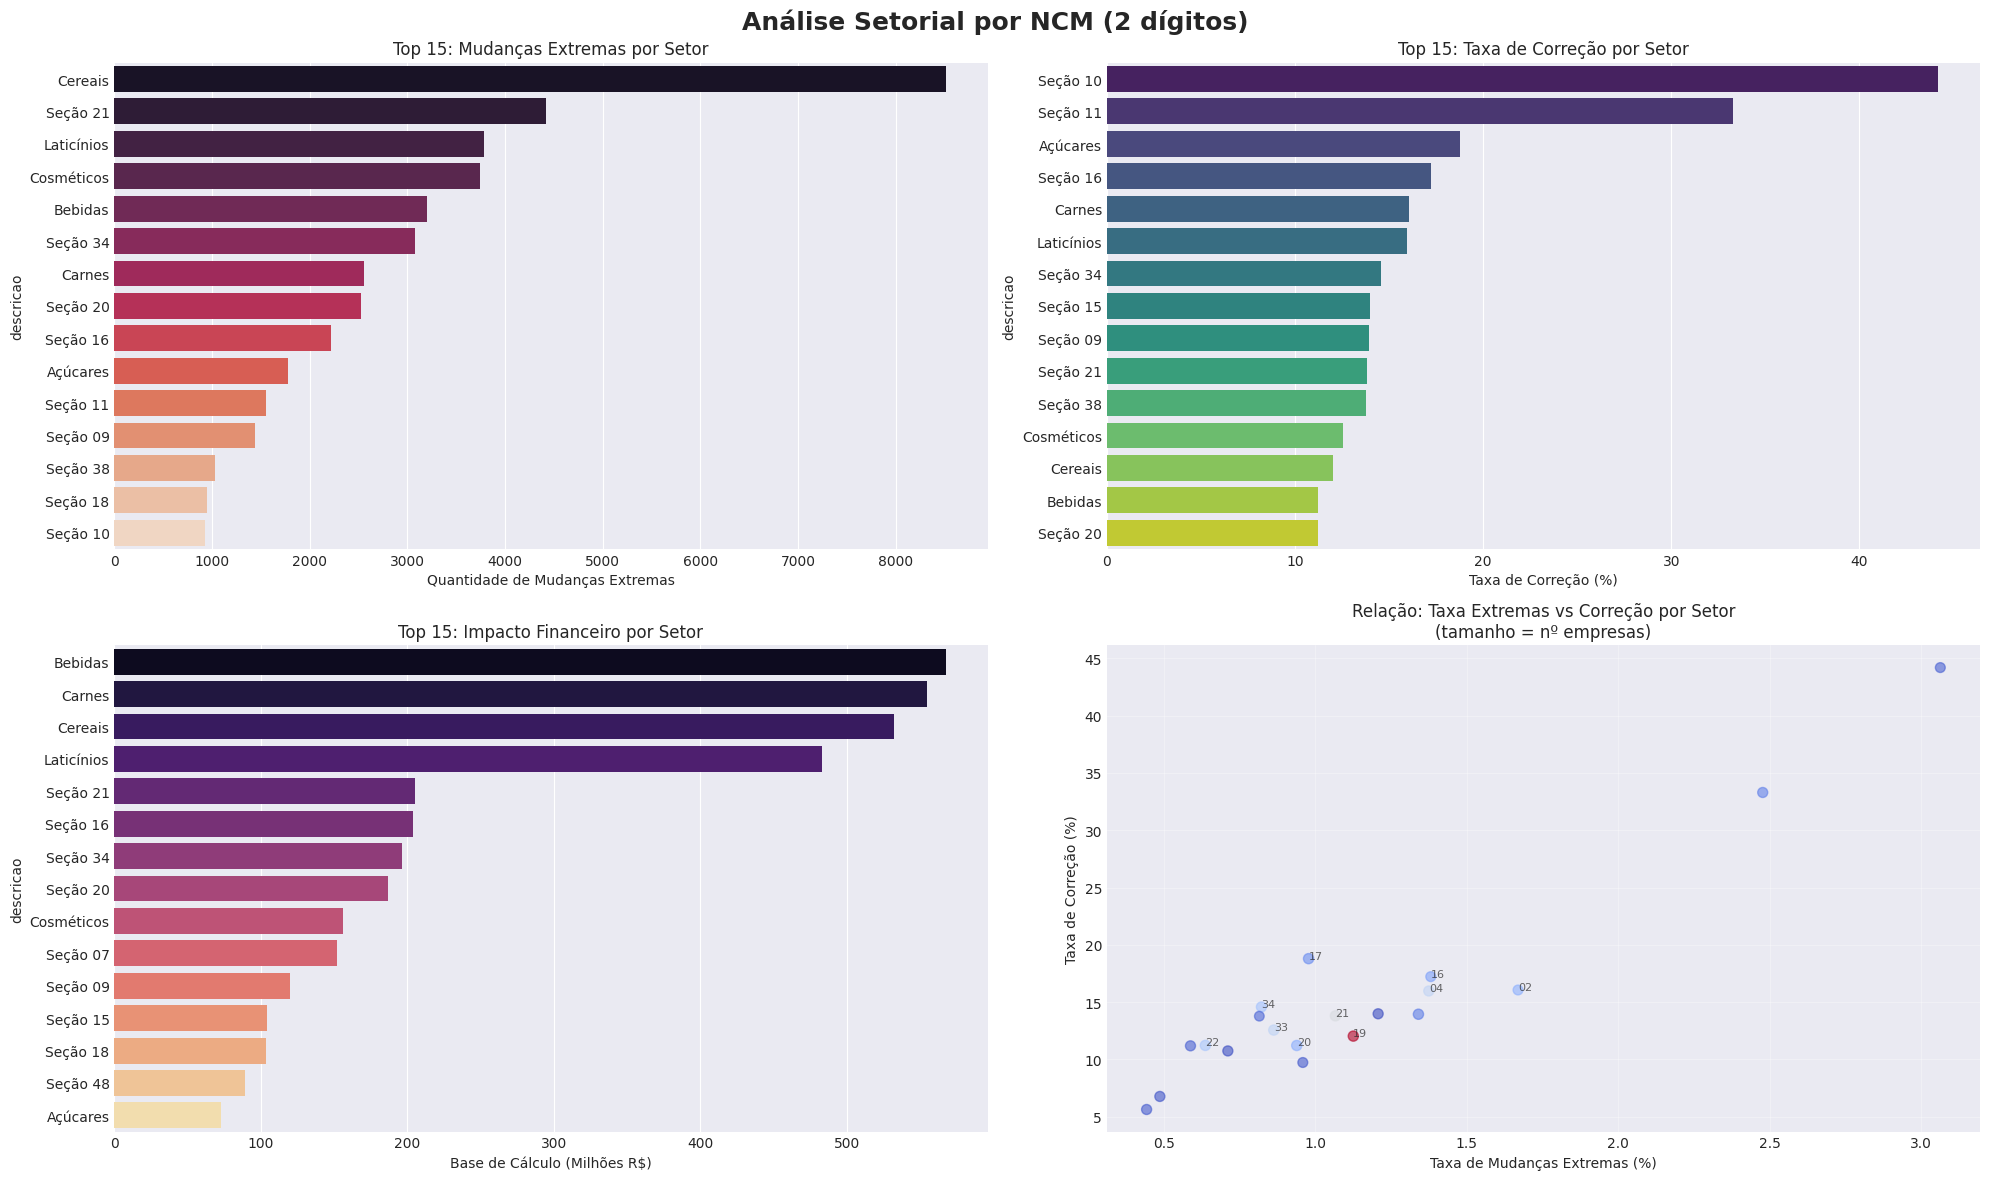

In [16]:
print("=" * 80)
print("5. ANÁLISE SETORIAL POR NCM (2 DÍGITOS)")
print("=" * 80)

# Query setorial
analise_setorial = spark.sql("""
SELECT 
    SUBSTR(CAST(ncm AS STRING), 1, 2) as setor_ncm,
    COUNT(*) as total_casos,
    COUNT(DISTINCT cnpj_emitente) as empresas,
    COUNT(DISTINCT CONCAT(gtin, '-', ncm)) as produtos,
    SUM(bc_total_periodo) as bc_total,
    SUM(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 1 ELSE 0 END) as mudancas_extremas,
    SUM(CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' THEN 1 ELSE 0 END) as aproximou_ia,
    AVG(diferenca_vs_ia_periodo) as diff_ia_media
FROM dados_argos
WHERE LENGTH(CAST(ncm AS STRING)) >= 2
GROUP BY SUBSTR(CAST(ncm AS STRING), 1, 2)
HAVING COUNT(*) >= 100
ORDER BY mudancas_extremas DESC
LIMIT 20
""")

setorial_pd = analise_setorial.toPandas()
setorial_pd['bc_total'] = setorial_pd['bc_total'].astype(float)
setorial_pd['taxa_extremas'] = (setorial_pd['mudancas_extremas'] / setorial_pd['total_casos'] * 100)
setorial_pd['taxa_correcao'] = (setorial_pd['aproximou_ia'] / setorial_pd['total_casos'] * 100)

# Dicionário de descrições NCM
ncm_desc = {
    '01': 'Animais Vivos', '02': 'Carnes', '04': 'Laticínios',
    '17': 'Açúcares', '19': 'Cereais', '22': 'Bebidas',
    '33': 'Cosméticos', '84': 'Máquinas', '85': 'Elétricos'
}
setorial_pd['descricao'] = setorial_pd['setor_ncm'].map(lambda x: ncm_desc.get(x, f'Seção {x}'))

# Exibir análise
print("\nTOP 20 SETORES POR MUDANÇAS EXTREMAS:")
for _, row in setorial_pd.iterrows():
    print(f"\nSetor {row['setor_ncm']}xx - {row['descricao']}")
    print(f"  Total: {row['total_casos']:,} casos | Empresas: {row['empresas']:,} | Produtos: {row['produtos']:,}")
    print(f"  Extremas: {row['mudancas_extremas']} ({row['taxa_extremas']:.1f}%)")
    print(f"  Taxa Correção: {row['taxa_correcao']:.1f}%")
    print(f"  BC Total: R$ {row['bc_total']:,.2f}")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Análise Setorial por NCM (2 dígitos)', fontsize=18, fontweight='bold')

# Gráfico 1: Mudanças extremas por setor
setorial_top15 = setorial_pd.head(15)
sns.barplot(data=setorial_top15, x='mudancas_extremas', y='descricao', 
            ax=axes[0,0], palette='rocket', orient='h')
axes[0,0].set_title('Top 15: Mudanças Extremas por Setor')
axes[0,0].set_xlabel('Quantidade de Mudanças Extremas')

# Gráfico 2: Taxa de correção
setorial_corr = setorial_pd.sort_values('taxa_correcao', ascending=False).head(15)
sns.barplot(data=setorial_corr, x='taxa_correcao', y='descricao', 
            ax=axes[0,1], palette='viridis', orient='h')
axes[0,1].set_title('Top 15: Taxa de Correção por Setor')
axes[0,1].set_xlabel('Taxa de Correção (%)')

# Gráfico 3: Impacto financeiro
setorial_bc = setorial_pd.sort_values('bc_total', ascending=False).head(15)
sns.barplot(data=setorial_bc, x=setorial_bc['bc_total']/1e6, y='descricao', 
            ax=axes[1,0], palette='magma', orient='h')
axes[1,0].set_title('Top 15: Impacto Financeiro por Setor')
axes[1,0].set_xlabel('Base de Cálculo (Milhões R$)')

# Gráfico 4: Scatter comparativo
axes[1,1].scatter(setorial_pd['taxa_extremas'], setorial_pd['taxa_correcao'], 
                  s=setorial_pd['empresas']*2, alpha=0.6, 
                  c=setorial_pd['mudancas_extremas'], cmap='coolwarm')
axes[1,1].set_xlabel('Taxa de Mudanças Extremas (%)')
axes[1,1].set_ylabel('Taxa de Correção (%)')
axes[1,1].set_title('Relação: Taxa Extremas vs Correção por Setor\n(tamanho = nº empresas)')
axes[1,1].grid(True, alpha=0.3)

# Adicionar labels aos pontos principais
for _, row in setorial_pd.head(10).iterrows():
    axes[1,1].annotate(row['setor_ncm'], 
                       (row['taxa_extremas'], row['taxa_correcao']),
                       fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

6. DASHBOARD EXECUTIVO - KPIs PRINCIPAIS



📊 MÉTRICAS PRINCIPAIS DO SISTEMA ARGOS:
  • Total de Registros Analisados: 4,553,767
  • Empresas Monitoradas: 28
  • Períodos Analisados: 34
  • Produtos Distintos: 73,209
  • Base de Cálculo Total: R$ 4,005,390,098.76

🎯 INDICADORES DE EFETIVIDADE:
  • Taxa de Correção Global: 14.1%
  • Empresas em Correção: 28 (100.0%)
  • Impacto Arrecadatário (Correções): R$ 17,197,410,333.20

⚠️ INDICADORES DE RISCO:
  • Mudanças Extremas: 43,342 (1.0%)
  • Mudanças Significativas: 108,337
  • Afastou da Alíquota Correta: 336,499

📈 ESTATÍSTICAS:
  • Diferença Média vs IA: -1498.63%
  • Desvio Padrão: ±621.62%


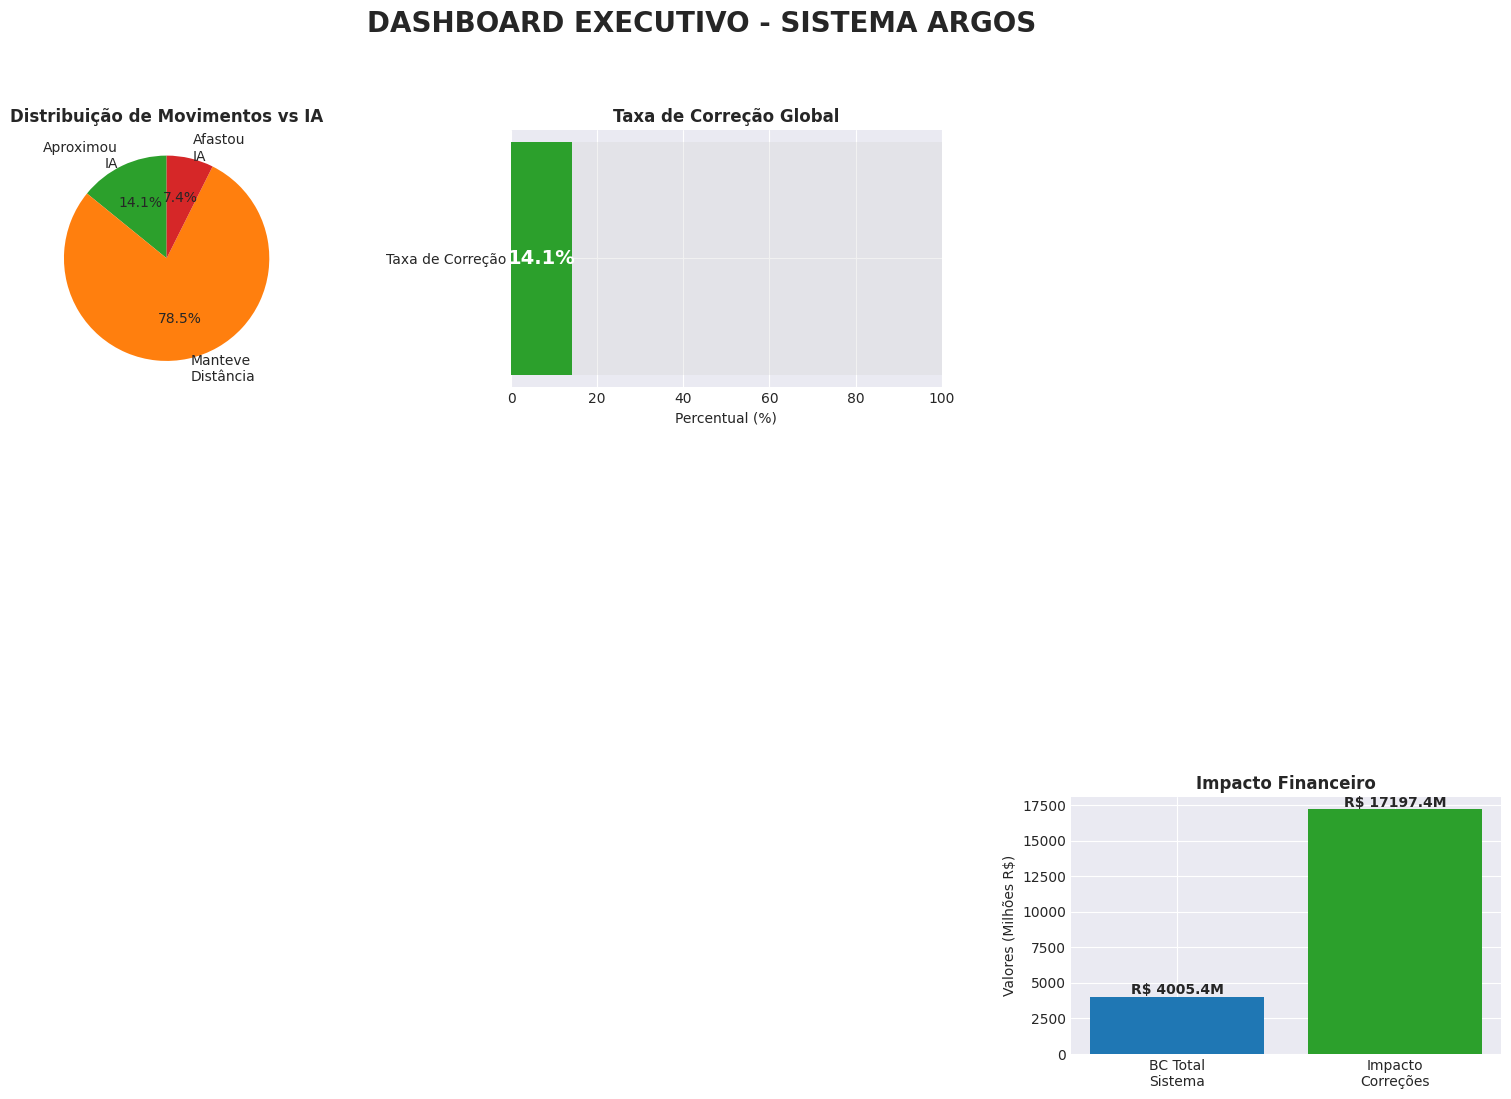

In [17]:
print("=" * 80)
print("6. DASHBOARD EXECUTIVO - KPIs PRINCIPAIS")
print("=" * 80)

# Query de KPIs
kpis = spark.sql("""
SELECT 
    COUNT(*) as total_registros,
    COUNT(DISTINCT cnpj_emitente) as total_empresas,
    COUNT(DISTINCT periodo) as total_periodos,
    COUNT(DISTINCT CONCAT(gtin, '-', ncm)) as total_produtos,
    SUM(bc_total_periodo) as bc_total_sistema,
    
    SUM(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 1 ELSE 0 END) as mudancas_extremas,
    SUM(CASE WHEN classificacao_mudanca = 'MUDANCA_SIGNIFICATIVA' THEN 1 ELSE 0 END) as mudancas_significativas,
    
    SUM(CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' THEN 1 ELSE 0 END) as aproximou_ia,
    SUM(CASE WHEN movimento_vs_ia = 'AFASTOU_DA_CORRETA' THEN 1 ELSE 0 END) as afastou_ia,
    SUM(CASE WHEN movimento_vs_ia = 'MANTEVE_DISTANCIA' THEN 1 ELSE 0 END) as manteve_distancia,
    
    SUM(CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' 
        THEN bc_total_periodo * ABS(diferenca_vs_ia_historica) ELSE 0 END) as impacto_correcoes,
    
    AVG(diferenca_vs_ia_periodo) as diff_ia_media,
    STDDEV(diferenca_vs_ia_periodo) as diff_ia_desvio
    
FROM niat.argos_mudanca_comportamento
WHERE movimento_vs_ia != 'SEM_REFERENCIA_IA'
  AND periodo >= '202301'
""")

kpi_data = kpis.collect()[0]

# Converter Decimals para float
bc_total_sistema = float(kpi_data['bc_total_sistema'])
impacto_correcoes = float(kpi_data['impacto_correcoes'])
diff_ia_media = float(kpi_data['diff_ia_media'])
diff_ia_desvio = float(kpi_data['diff_ia_desvio'])

# Calcular métricas derivadas
taxa_correcao_global = (kpi_data['aproximou_ia'] / kpi_data['total_registros'] * 100)
taxa_extremas = (kpi_data['mudancas_extremas'] / kpi_data['total_registros'] * 100)
empresas_corrigindo = spark.sql("""
    SELECT COUNT(DISTINCT cnpj_emitente) as qtd
    FROM niat.argos_mudanca_comportamento 
    WHERE movimento_vs_ia = 'APROXIMOU_DA_CORRETA'
      AND periodo >= '202301'
""").collect()[0]['qtd']

# Exibir KPIs
print(f"\n📊 MÉTRICAS PRINCIPAIS DO SISTEMA ARGOS:")
print(f"  • Total de Registros Analisados: {kpi_data['total_registros']:,}")
print(f"  • Empresas Monitoradas: {kpi_data['total_empresas']:,}")
print(f"  • Períodos Analisados: {kpi_data['total_periodos']}")
print(f"  • Produtos Distintos: {kpi_data['total_produtos']:,}")
print(f"  • Base de Cálculo Total: R$ {bc_total_sistema:,.2f}")

print(f"\n🎯 INDICADORES DE EFETIVIDADE:")
print(f"  • Taxa de Correção Global: {taxa_correcao_global:.1f}%")
print(f"  • Empresas em Correção: {empresas_corrigindo:,} ({empresas_corrigindo/kpi_data['total_empresas']*100:.1f}%)")
print(f"  • Impacto Arrecadatário (Correções): R$ {impacto_correcoes:,.2f}")

print(f"\n⚠️ INDICADORES DE RISCO:")
print(f"  • Mudanças Extremas: {kpi_data['mudancas_extremas']:,} ({taxa_extremas:.1f}%)")
print(f"  • Mudanças Significativas: {kpi_data['mudancas_significativas']:,}")
print(f"  • Afastou da Alíquota Correta: {kpi_data['afastou_ia']:,}")

print(f"\n📈 ESTATÍSTICAS:")
print(f"  • Diferença Média vs IA: {diff_ia_media*100:+.2f}%")
print(f"  • Desvio Padrão: ±{diff_ia_desvio*100:.2f}%")

# Visualização Dashboard (com conversões corretas)
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# KPI 1: Distribuição de Movimentos
ax1 = fig.add_subplot(gs[0, 0])
movimentos = ['Aproximou\nIA', 'Manteve\nDistância', 'Afastou\nIA']
valores_mov = [kpi_data['aproximou_ia'], kpi_data['manteve_distancia'], kpi_data['afastou_ia']]
cores_mov = ['#2ca02c', '#ff7f0e', '#d62728']
ax1.pie(valores_mov, labels=movimentos, autopct='%1.1f%%', colors=cores_mov, startangle=90)
ax1.set_title('Distribuição de Movimentos vs IA', fontweight='bold')

# KPI 2: Taxa de Correção
ax2 = fig.add_subplot(gs[0, 1])
ax2.barh(['Taxa de Correção'], [taxa_correcao_global], color='#2ca02c', height=0.5)
ax2.barh(['Taxa de Correção'], [100-taxa_correcao_global], left=[taxa_correcao_global], 
         color='lightgray', height=0.5, alpha=0.3)
ax2.set_xlim(0, 100)
ax2.set_xlabel('Percentual (%)')
ax2.set_title('Taxa de Correção Global', fontweight='bold')
ax2.text(taxa_correcao_global/2, 0, f'{taxa_correcao_global:.1f}%', 
         ha='center', va='center', fontsize=14, fontweight='bold', color='white')

# KPI 7: Impacto Financeiro (CORRIGIDO)
ax7 = fig.add_subplot(gs[2, 2])
impactos = ['BC Total\nSistema', 'Impacto\nCorreções']
valores_impacto = [bc_total_sistema/1e6, impacto_correcoes/1e6]  # Agora são floats
cores_impacto = ['#1f77b4', '#2ca02c']
bars = ax7.bar(impactos, valores_impacto, color=cores_impacto)
ax7.set_ylabel('Valores (Milhões R$)')
ax7.set_title('Impacto Financeiro', fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax7.text(bar.get_x() + bar.get_width()/2., height,
             f'R$ {height:.1f}M', ha='center', va='bottom', fontweight='bold')

plt.suptitle('DASHBOARD EXECUTIVO - SISTEMA ARGOS', fontsize=20, fontweight='bold', y=0.98)
plt.show()

7. ANÁLISE DE PRODUTOS COM MAIOR VOLATILIDADE



TOP 30 PRODUTOS COM MAIOR VOLATILIDADE:

1. WHISKY 750ML JAMESON
   GTIN: 5011007003029 | NCM: 22083020
   Empresas: 3 | Períodos: 10
   Alíquota IA: 0.00% | Praticada Média: 12.50%
   Desvio: ±13.06% | Range: 0.00% a 25.00%
   BC Total: R$ 1,866.70 | Mudanças Relevantes: 1

2. AGUARDENTE CHAPEU PA
   GTIN: 7896092504938 | NCM: 22084000
   Empresas: 3 | Períodos: 11
   Alíquota IA: 0.00% | Praticada Média: 13.46%
   Desvio: ±12.97% | Range: 0.00% a 25.00%
   BC Total: R$ 1,356.07 | Mudanças Relevantes: 2

3. WHISKY BALLANTINES 7
   GTIN: 5010106113530 | NCM: 22083020
   Empresas: 3 | Períodos: 12
   Alíquota IA: 0.00% | Praticada Média: 13.33%
   Desvio: ±12.91% | Range: 0.00% a 25.00%
   BC Total: R$ 2,233.07 | Mudanças Relevantes: 2

4. WHISKY SCOTCH BELLS
   GTIN: 5000387905634 | NCM: 22089000
   Empresas: 3 | Períodos: 12
   Alíquota IA: 0.00% | Praticada Média: 10.71%
   Desvio: ±12.84% | Range: 0.00% a 25.00%
   BC Total: R$ 966.12 | Mudanças Relevantes: 4

5. WHISKY JOHNNIE WAL

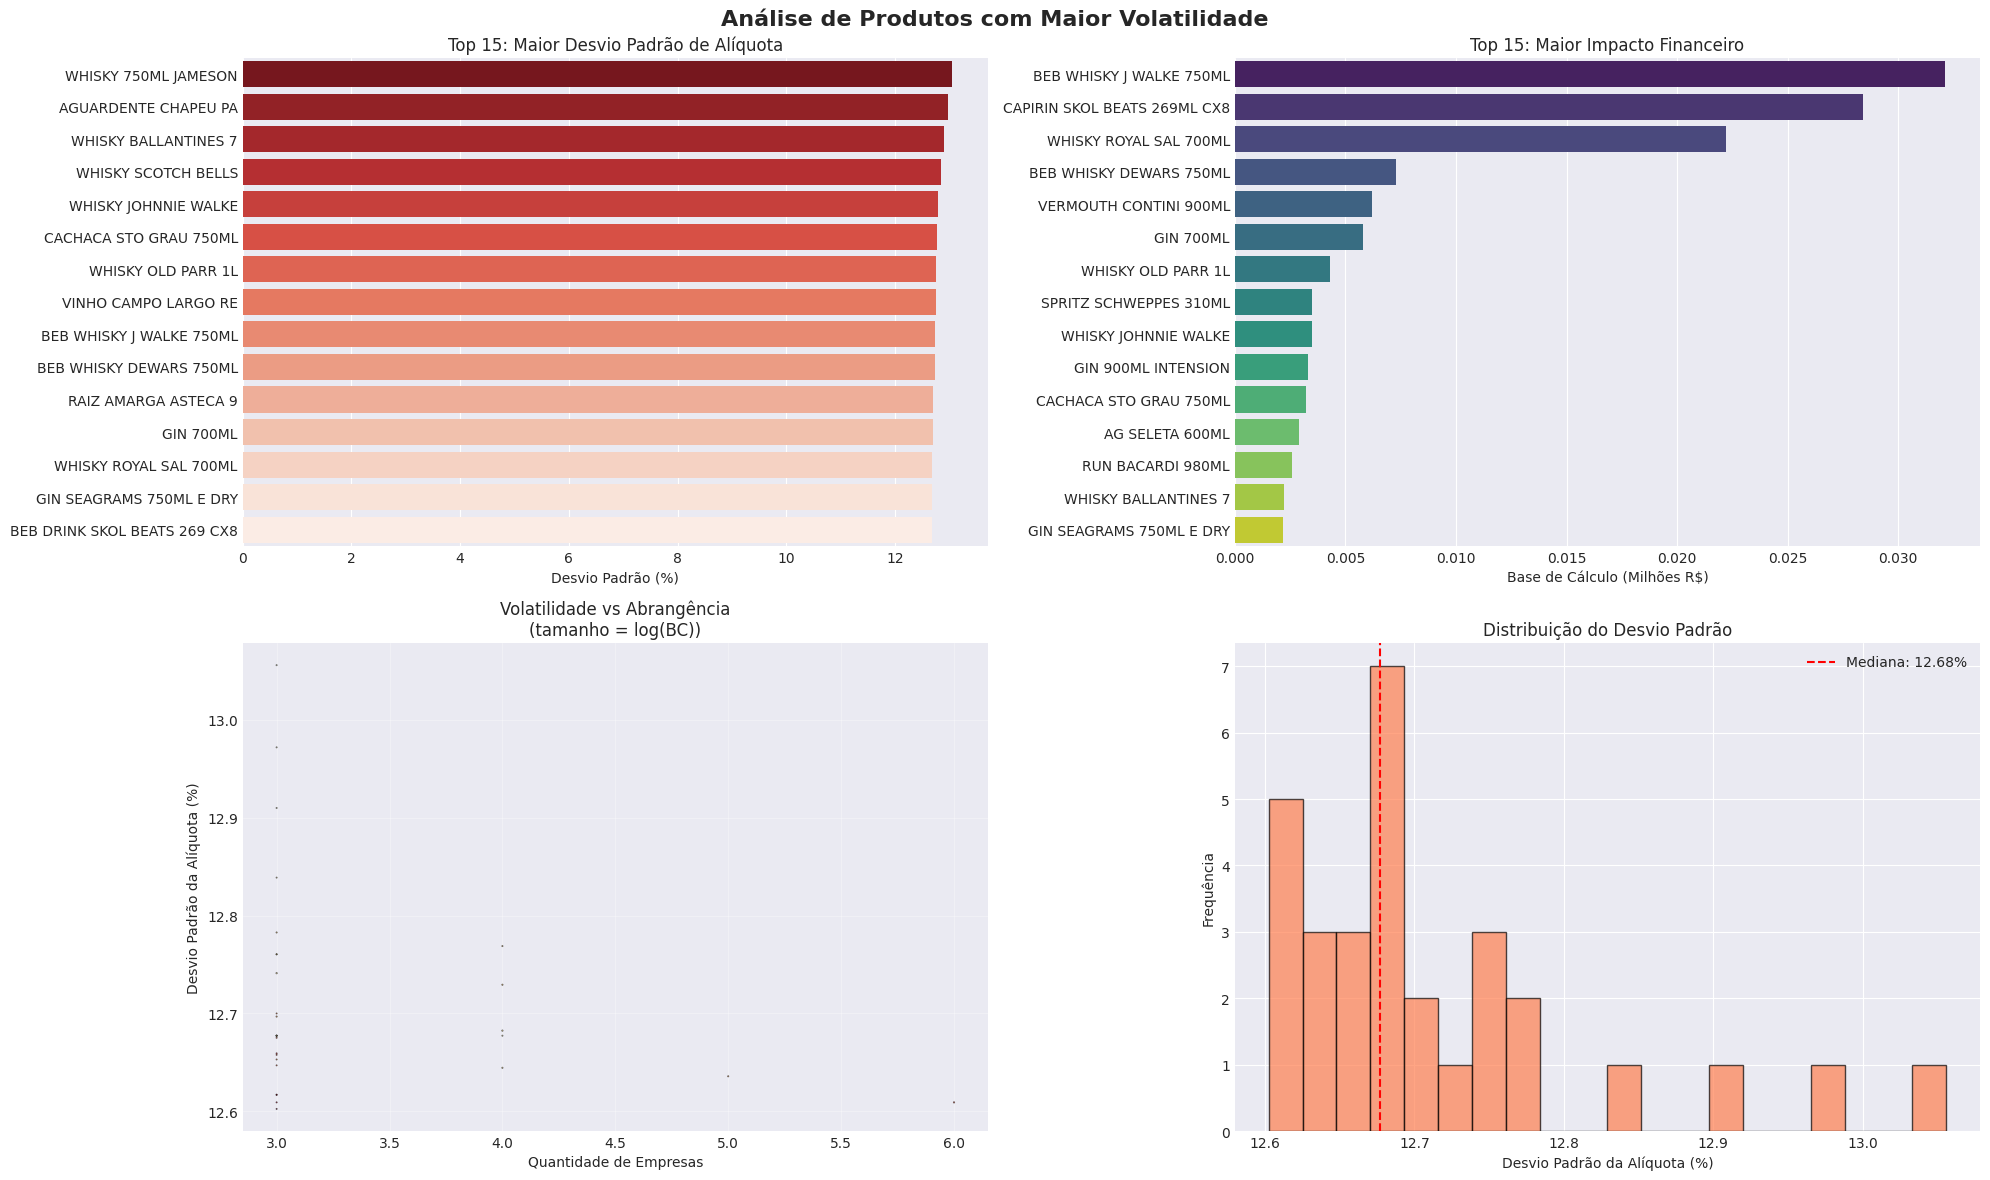

In [18]:
print("=" * 80)
print("7. ANÁLISE DE PRODUTOS COM MAIOR VOLATILIDADE")
print("=" * 80)

# Query de produtos
produtos_volateis = spark.sql("""
SELECT 
    gtin,
    ncm,
    descricao,
    aliquota_ia,
    COUNT(DISTINCT cnpj_emitente) as qtd_empresas,
    COUNT(DISTINCT periodo) as qtd_periodos,
    COUNT(*) as total_registros,
    AVG(aliq_emitente_periodo) as aliq_media,
    STDDEV(aliq_emitente_periodo) as aliq_desvio,
    MIN(aliq_emitente_periodo) as aliq_minima,
    MAX(aliq_emitente_periodo) as aliq_maxima,
    AVG(diferenca_vs_ia_periodo) as diff_ia_media,
    SUM(bc_total_periodo) as bc_total,
    SUM(CASE WHEN classificacao_mudanca IN ('MUDANCA_EXTREMA', 'MUDANCA_SIGNIFICATIVA') 
        THEN 1 ELSE 0 END) as mudancas_relevantes
FROM niat.argos_mudanca_comportamento
WHERE aliquota_ia IS NOT NULL
  AND periodo >= '202301'
GROUP BY gtin, ncm, descricao, aliquota_ia
HAVING COUNT(DISTINCT cnpj_emitente) >= 3
ORDER BY aliq_desvio DESC, bc_total DESC
LIMIT 30
""")

produtos_pd = produtos_volateis.toPandas()

# Converter TODOS os campos numéricos de Decimal para float
numeric_cols = ['aliquota_ia', 'aliq_media', 'aliq_desvio', 'aliq_minima', 
                'aliq_maxima', 'diff_ia_media', 'bc_total']
for col in numeric_cols:
    if col in produtos_pd.columns:
        produtos_pd[col] = pd.to_numeric(produtos_pd[col], errors='coerce')

# Calcular coeficiente de variação (agora com valores float)
produtos_pd['coef_variacao'] = produtos_pd.apply(
    lambda row: (row['aliq_desvio'] / row['aliq_media'] * 100) 
    if row['aliq_media'] != 0 else 0, axis=1
)

# Exibir produtos
print("\nTOP 30 PRODUTOS COM MAIOR VOLATILIDADE:")
for i, row in produtos_pd.head(15).iterrows():
    print(f"\n{i+1}. {row['descricao'][:50]}")
    print(f"   GTIN: {row['gtin']} | NCM: {row['ncm']}")
    print(f"   Empresas: {int(row['qtd_empresas'])} | Períodos: {int(row['qtd_periodos'])}")
    print(f"   Alíquota IA: {row['aliquota_ia']*100:.2f}% | Praticada Média: {row['aliq_media']*100:.2f}%")
    print(f"   Desvio: ±{row['aliq_desvio']*100:.2f}% | Range: {row['aliq_minima']*100:.2f}% a {row['aliq_maxima']*100:.2f}%")
    print(f"   BC Total: R$ {row['bc_total']:,.2f} | Mudanças Relevantes: {int(row['mudancas_relevantes'])}")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Análise de Produtos com Maior Volatilidade', fontsize=16, fontweight='bold')

# Gráfico 1: Top 15 por desvio padrão
top15_vol = produtos_pd.head(15)
sns.barplot(data=top15_vol, y='descricao', x=top15_vol['aliq_desvio']*100, 
            ax=axes[0,0], palette='Reds_r', orient='h')
axes[0,0].set_title('Top 15: Maior Desvio Padrão de Alíquota')
axes[0,0].set_xlabel('Desvio Padrão (%)')
axes[0,0].set_ylabel('')

# Gráfico 2: Impacto financeiro
top15_bc = produtos_pd.nlargest(15, 'bc_total')
sns.barplot(data=top15_bc, y='descricao', x=top15_bc['bc_total']/1e6, 
            ax=axes[0,1], palette='viridis', orient='h')
axes[0,1].set_title('Top 15: Maior Impacto Financeiro')
axes[0,1].set_xlabel('Base de Cálculo (Milhões R$)')
axes[0,1].set_ylabel('')

# Gráfico 3: Scatter - Volatilidade vs Empresas
axes[1,0].scatter(produtos_pd['qtd_empresas'], produtos_pd['aliq_desvio']*100, 
                  s=np.log1p(produtos_pd['bc_total'])/10, alpha=0.6, 
                  c=produtos_pd['mudancas_relevantes'], cmap='YlOrRd',
                  edgecolors='black', linewidth=0.5)
axes[1,0].set_xlabel('Quantidade de Empresas')
axes[1,0].set_ylabel('Desvio Padrão da Alíquota (%)')
axes[1,0].set_title('Volatilidade vs Abrangência\n(tamanho = log(BC))')
axes[1,0].grid(True, alpha=0.3)

# Gráfico 4: Histograma de desvio padrão
axes[1,1].hist(produtos_pd['aliq_desvio']*100, bins=20, color='coral', 
               edgecolor='black', alpha=0.7)
axes[1,1].set_xlabel('Desvio Padrão da Alíquota (%)')
axes[1,1].set_ylabel('Frequência')
axes[1,1].set_title('Distribuição do Desvio Padrão')
axes[1,1].axvline(produtos_pd['aliq_desvio'].median()*100, color='red', 
                  linestyle='--', label=f'Mediana: {produtos_pd["aliq_desvio"].median()*100:.2f}%')
axes[1,1].legend()

plt.tight_layout()
plt.show()

8. IDENTIFICAÇÃO DE EMPRESAS COM COMPORTAMENTO SISTEMÁTICO



EMPRESAS COM COMPORTAMENTO SISTEMÁTICO:

1. PONTO ALTO DISTRIBUIDORA DE PRODUTOS ALIMENTICIOS 
   Perfil: MODERADO - Comportamento Irregular
   Casos: 87,848 | Períodos: 22
   Taxa Extremas: 2.2% | Taxa Afastou IA: 20.9%
   Diferença IA Média: -1632.70% (±540.10%)
   BC Total: R$ 107,446,229.13

2. RWR LOGISTICA E DISTRIBUICAO LTDA
   Perfil: MODERADO - Comportamento Irregular
   Casos: 216,461 | Períodos: 33
   Taxa Extremas: 2.1% | Taxa Afastou IA: 16.6%
   Diferença IA Média: -1551.38% (±595.91%)
   BC Total: R$ 232,917,592.89

3. SDB COMERCIO DE ALIMENTOS LTDA
   Perfil: MODERADO - Comportamento Irregular
   Casos: 258,768 | Períodos: 33
   Taxa Extremas: 1.8% | Taxa Afastou IA: 3.5%
   Diferença IA Média: -1478.28% (±641.01%)
   BC Total: R$ 535,996,674.97

4. SDB COMERCIO DE ALIMENTOS LTDA
   Perfil: MODERADO - Comportamento Irregular
   Casos: 343,876 | Períodos: 34
   Taxa Extremas: 1.6% | Taxa Afastou IA: 4.0%
   Diferença IA Média: -1469.62% (±657.60%)
   BC Total: R$ 1,009,

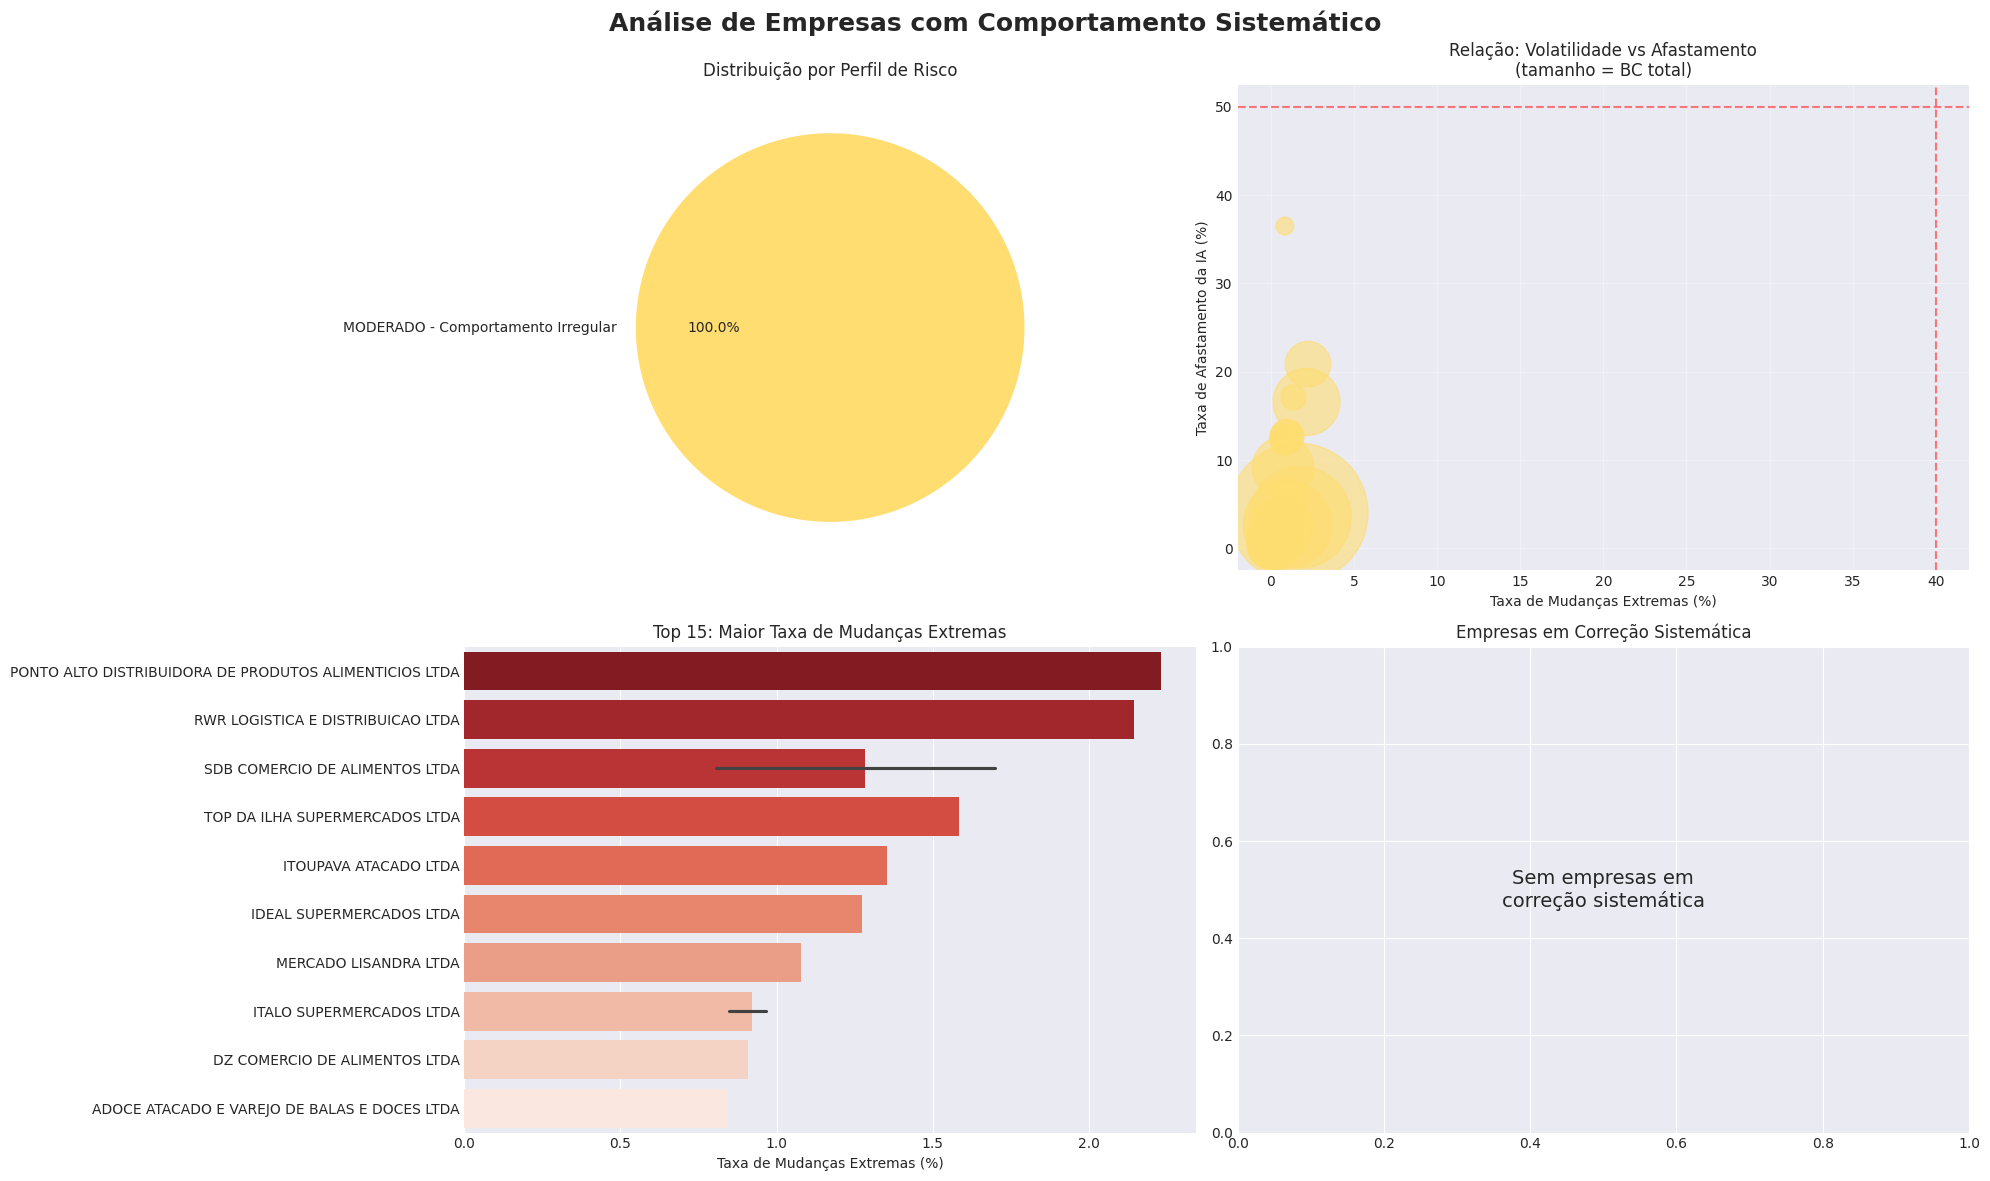

In [19]:
print("=" * 80)
print("8. IDENTIFICAÇÃO DE EMPRESAS COM COMPORTAMENTO SISTEMÁTICO")
print("=" * 80)

# Query de empresas sistemáticas
empresas_sistematicas = spark.sql("""
WITH empresa_analise AS (
    SELECT 
        cnpj_emitente,
        nm_razao_social,
        COUNT(*) as total_casos,
        COUNT(DISTINCT periodo) as periodos_ativos,
        SUM(bc_total_periodo) as bc_total,
        AVG(diferenca_vs_ia_periodo) as diff_ia_media,
        STDDEV(diferenca_vs_ia_periodo) as diff_ia_desvio,
        
        -- Padrões de comportamento
        SUM(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 1 ELSE 0 END) as mudancas_extremas,
        SUM(CASE WHEN movimento_vs_ia = 'AFASTOU_DA_CORRETA' THEN 1 ELSE 0 END) as afastou_ia,
        SUM(CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' THEN 1 ELSE 0 END) as aproximou_ia,
        
        -- Taxas percentuais
        AVG(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 100.0 ELSE 0.0 END) as taxa_extremas,
        AVG(CASE WHEN movimento_vs_ia = 'AFASTOU_DA_CORRETA' THEN 100.0 ELSE 0.0 END) as taxa_afastou
        
    FROM dados_argos
    WHERE movimento_vs_ia != 'SEM_REFERENCIA_IA'
    GROUP BY cnpj_emitente, nm_razao_social
    HAVING COUNT(*) >= 10
)
SELECT 
    *,
    CASE 
        WHEN taxa_extremas >= 60 AND taxa_afastou >= 50 THEN 'CRÍTICO - Afastamento Sistemático'
        WHEN taxa_extremas >= 40 THEN 'ALTO RISCO - Alta Volatilidade'
        WHEN taxa_afastou >= 60 THEN 'ALTO RISCO - Piora Consistente'
        WHEN aproximou_ia >= (total_casos * 0.6) THEN 'POSITIVO - Correção Sistemática'
        ELSE 'MODERADO - Comportamento Irregular'
    END as perfil_risco
FROM empresa_analise
ORDER BY taxa_extremas DESC, taxa_afastou DESC, bc_total DESC
LIMIT 30
""")

sist_pd = empresas_sistematicas.toPandas()
sist_pd['bc_total'] = sist_pd['bc_total'].astype(float)

# Exibir empresas sistemáticas
print("\nEMPRESAS COM COMPORTAMENTO SISTEMÁTICO:")
for i, row in sist_pd.iterrows():
    print(f"\n{i+1}. {row['nm_razao_social'][:50]}")
    print(f"   Perfil: {row['perfil_risco']}")
    print(f"   Casos: {row['total_casos']:,} | Períodos: {row['periodos_ativos']}")
    print(f"   Taxa Extremas: {row['taxa_extremas']:.1f}% | Taxa Afastou IA: {row['taxa_afastou']:.1f}%")
    print(f"   Diferença IA Média: {row['diff_ia_media']*100:+.2f}% (±{row['diff_ia_desvio']*100:.2f}%)")
    print(f"   BC Total: R$ {row['bc_total']:,.2f}")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Análise de Empresas com Comportamento Sistemático', fontsize=18, fontweight='bold')

# Gráfico 1: Distribuição por perfil
perfil_dist = sist_pd['perfil_risco'].value_counts()
colors_perfil = {'CRÍTICO - Afastamento Sistemático': '#d62728',
                 'ALTO RISCO - Alta Volatilidade': '#ff7f0e',
                 'ALTO RISCO - Piora Consistente': '#ff9896',
                 'POSITIVO - Correção Sistemática': '#2ca02c',
                 'MODERADO - Comportamento Irregular': '#ffdd70'}
axes[0,0].pie(perfil_dist.values, labels=perfil_dist.index, autopct='%1.1f%%',
              colors=[colors_perfil.get(x, '#gray') for x in perfil_dist.index])
axes[0,0].set_title('Distribuição por Perfil de Risco')

# Gráfico 2: Taxa extremas vs Taxa afastou
scatter_colors = [colors_perfil.get(x, 'gray') for x in sist_pd['perfil_risco']]
axes[0,1].scatter(sist_pd['taxa_extremas'], sist_pd['taxa_afastou'], 
                  s=sist_pd['bc_total']/1e5, alpha=0.6, c=scatter_colors)
axes[0,1].set_xlabel('Taxa de Mudanças Extremas (%)')
axes[0,1].set_ylabel('Taxa de Afastamento da IA (%)')
axes[0,1].set_title('Relação: Volatilidade vs Afastamento\n(tamanho = BC total)')
axes[0,1].axhline(y=50, color='red', linestyle='--', alpha=0.5)
axes[0,1].axvline(x=40, color='red', linestyle='--', alpha=0.5)
axes[0,1].grid(True, alpha=0.3)

# Gráfico 3: Top 15 por taxa de extremas
top15_sist = sist_pd.head(15)
sns.barplot(data=top15_sist, y='nm_razao_social', x='taxa_extremas', 
            ax=axes[1,0], palette='Reds_r', orient='h')
axes[1,0].set_title('Top 15: Maior Taxa de Mudanças Extremas')
axes[1,0].set_xlabel('Taxa de Mudanças Extremas (%)')
axes[1,0].set_ylabel('')

# Gráfico 4: Empresas em correção
empresas_positivas = sist_pd[sist_pd['perfil_risco'] == 'POSITIVO - Correção Sistemática'].head(10)
if not empresas_positivas.empty:
    sns.barplot(data=empresas_positivas, y='nm_razao_social', x='aproximou_ia', 
                ax=axes[1,1], palette='Greens_r', orient='h')
    axes[1,1].set_title('Top 10: Empresas em Correção Sistemática')
    axes[1,1].set_xlabel('Quantidade de Casos Corrigidos')
    axes[1,1].set_ylabel('')
else:
    axes[1,1].text(0.5, 0.5, 'Sem empresas em\ncorreção sistemática', 
                   ha='center', va='center', fontsize=14)
    axes[1,1].set_title('Empresas em Correção Sistemática')

plt.tight_layout()
plt.show()

9. ANÁLISE DE IMPACTO ARRECADATÓRIO POTENCIAL



💰 IMPACTO ARRECADATÓRIO CONSOLIDADO:
  • Impacto Total Estimado: R$ 4,771,066,119.35
  • Impacto Já Realizado: R$ 2,753,338,602.78
  • Potencial Remanescente: R$ 2,017,727,516.56
  • Taxa de Realização: 57.7%

TOP 20 PRODUTOS POR IMPACTO ARRECADATÓRIO:

1. PAO FRANCES KG
   NCM: 19059090 | Empresas: 13
   Impacto Total: R$ 327,811,610.02
   Impacto Realizado: R$ 175,692,778.24 (53.6%)
   Potencial: R$ 152,118,831.78
   Empresas Corrigindo: 5/13 (38.5%)

2. CONTRA FILE BOV FRIBOI K
   NCM: 02013000 | Empresas: 10
   Impacto Total: R$ 215,971,987.11
   Impacto Realizado: R$ 156,559,243.63 (72.5%)
   Potencial: R$ 59,412,743.49
   Empresas Corrigindo: 4/10 (40.0%)

3. LEITE ITALAC INTEG 1L
   NCM: 04012010 | Empresas: 10
   Impacto Total: R$ 187,460,171.30
   Impacto Realizado: R$ 11,648,431.93 (6.2%)
   Potencial: R$ 175,811,739.37
   Empresas Corrigindo: 6/10 (60.0%)

4. CAFE MELITTA 500G VACUO
   NCM: 09012100 | Empresas: 10
   Impacto Total: R$ 170,840,262.36
   Impacto Realizado: R$

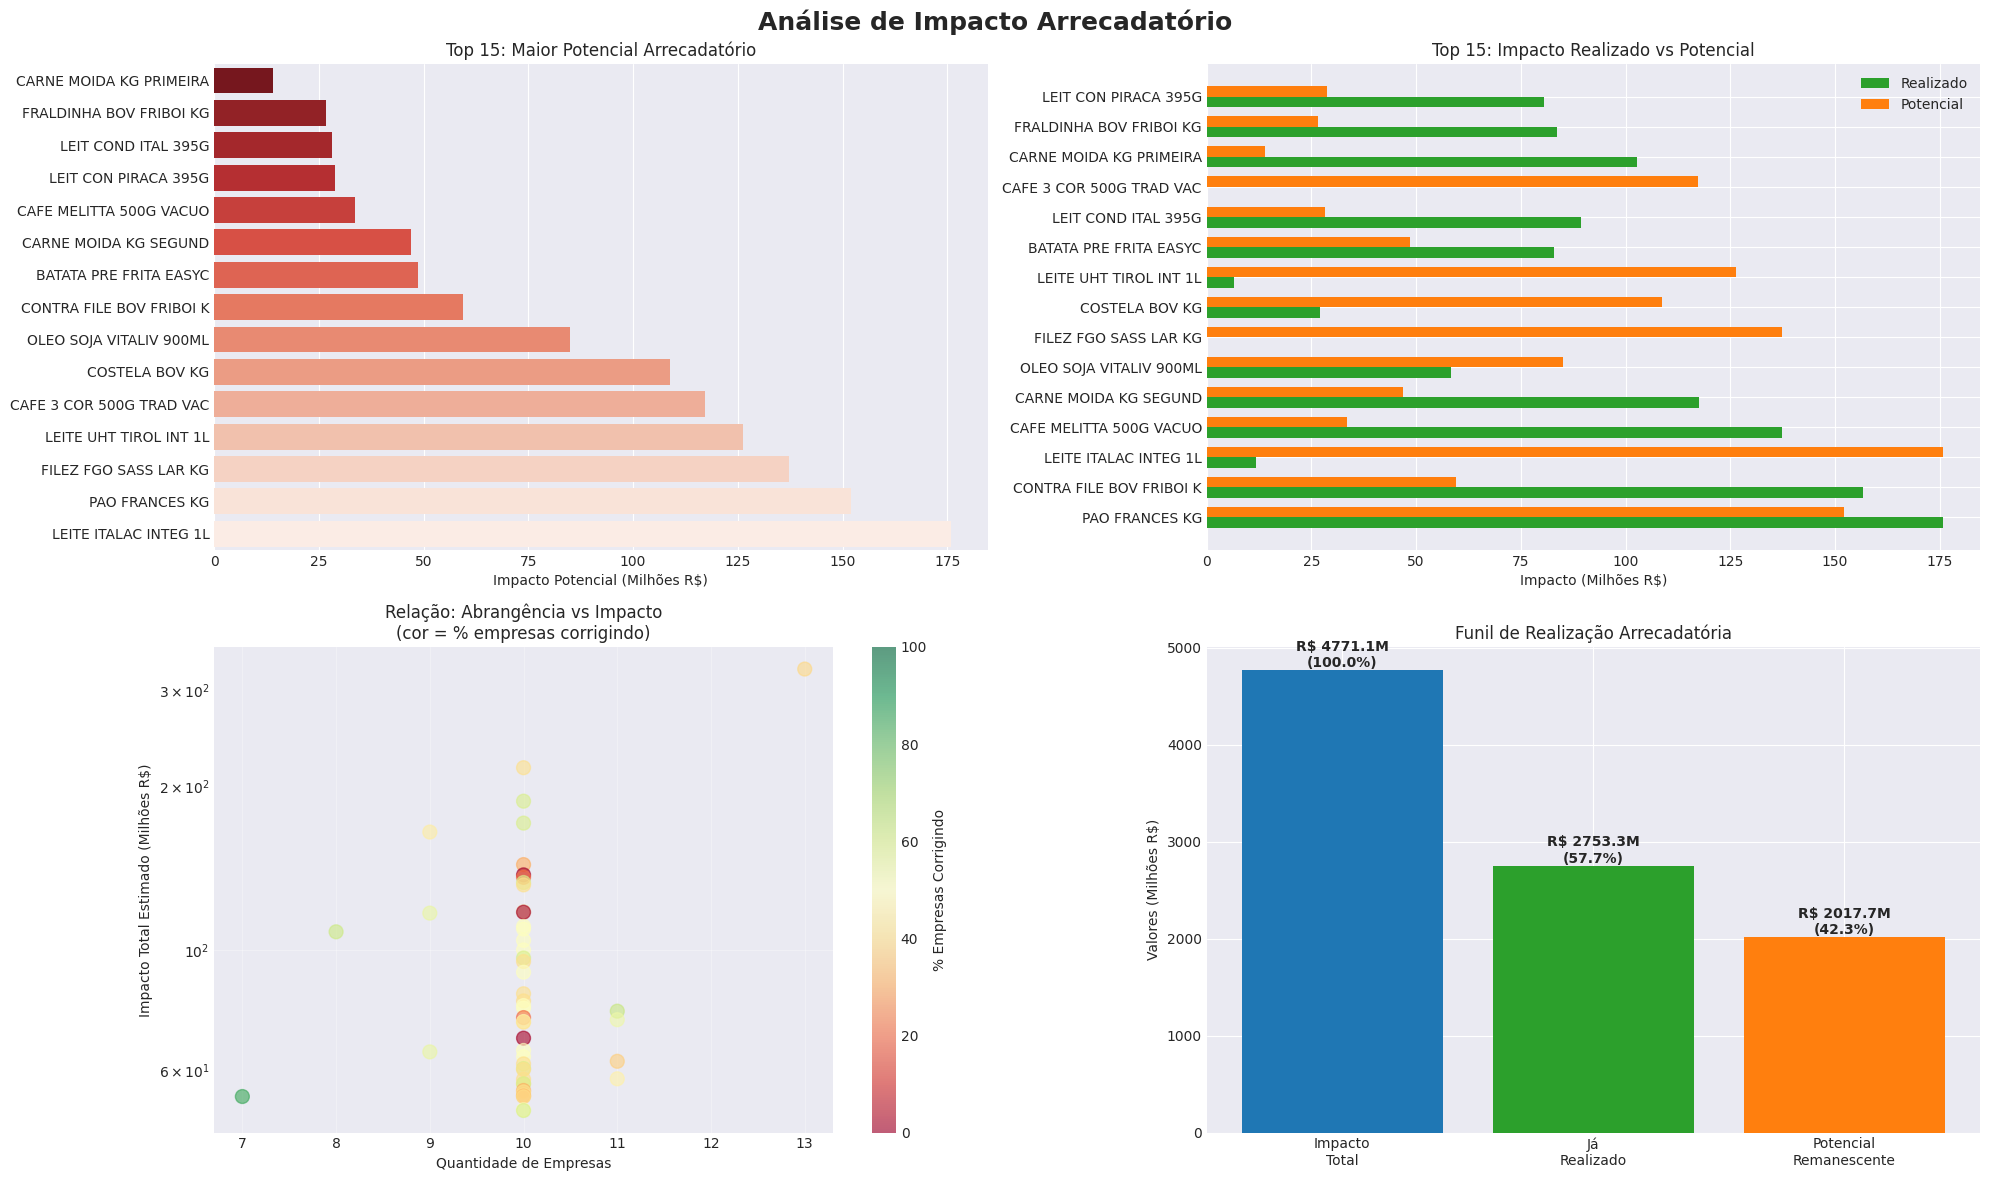

In [20]:
print("=" * 80)
print("9. ANÁLISE DE IMPACTO ARRECADATÓRIO POTENCIAL")
print("=" * 80)

# Query de impacto
impacto_arrecadatorio = spark.sql("""
SELECT 
    gtin,
    ncm,
    descricao,
    aliquota_ia,
    COUNT(DISTINCT cnpj_emitente) as qtd_empresas,
    SUM(bc_total_periodo) as bc_total,
    AVG(aliq_emitente_periodo - aliquota_ia) as diff_media,
    
    -- Impacto estimado se todos corrigissem
    SUM(bc_total_periodo * ABS(aliq_emitente_periodo - aliquota_ia)) as impacto_total_estimado,
    
    -- Empresas já corrigindo
    COUNT(DISTINCT CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' 
                   THEN cnpj_emitente END) as empresas_corrigindo,
    
    -- Impacto já realizado
    SUM(CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' 
        THEN bc_total_periodo * ABS(diferenca_vs_ia_historica) ELSE 0 END) as impacto_realizado
    
FROM dados_argos
WHERE aliquota_ia IS NOT NULL
  AND ABS(aliq_emitente_periodo - aliquota_ia) > 0.01
GROUP BY gtin, ncm, descricao, aliquota_ia
HAVING COUNT(DISTINCT cnpj_emitente) >= 3
ORDER BY impacto_total_estimado DESC
LIMIT 50
""")

impacto_pd = impacto_arrecadatorio.toPandas()
impacto_pd['bc_total'] = impacto_pd['bc_total'].astype(float)
impacto_pd['impacto_total_estimado'] = impacto_pd['impacto_total_estimado'].astype(float)
impacto_pd['impacto_realizado'] = impacto_pd['impacto_realizado'].astype(float)
impacto_pd['impacto_potencial'] = impacto_pd['impacto_total_estimado'] - impacto_pd['impacto_realizado']
impacto_pd['perc_empresas_corrigindo'] = (impacto_pd['empresas_corrigindo'] / impacto_pd['qtd_empresas'] * 100)

# Totais
impacto_total_sistema = impacto_pd['impacto_total_estimado'].sum()
impacto_realizado_sistema = impacto_pd['impacto_realizado'].sum()
impacto_potencial_sistema = impacto_pd['impacto_potencial'].sum()

print(f"\n💰 IMPACTO ARRECADATÓRIO CONSOLIDADO:")
print(f"  • Impacto Total Estimado: R$ {impacto_total_sistema:,.2f}")
print(f"  • Impacto Já Realizado: R$ {impacto_realizado_sistema:,.2f}")
print(f"  • Potencial Remanescente: R$ {impacto_potencial_sistema:,.2f}")
print(f"  • Taxa de Realização: {impacto_realizado_sistema/impacto_total_sistema*100:.1f}%")

print(f"\nTOP 20 PRODUTOS POR IMPACTO ARRECADATÓRIO:")
for i, row in impacto_pd.head(20).iterrows():
    print(f"\n{i+1}. {row['descricao'][:50]}")
    print(f"   NCM: {row['ncm']} | Empresas: {row['qtd_empresas']}")
    print(f"   Impacto Total: R$ {row['impacto_total_estimado']:,.2f}")
    print(f"   Impacto Realizado: R$ {row['impacto_realizado']:,.2f} ({row['impacto_realizado']/row['impacto_total_estimado']*100:.1f}%)")
    print(f"   Potencial: R$ {row['impacto_potencial']:,.2f}")
    print(f"   Empresas Corrigindo: {row['empresas_corrigindo']}/{row['qtd_empresas']} ({row['perc_empresas_corrigindo']:.1f}%)")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Análise de Impacto Arrecadatório', fontsize=18, fontweight='bold')

# Gráfico 1: Top 15 por impacto potencial
top15_impacto = impacto_pd.head(15).sort_values('impacto_potencial', ascending=True)
sns.barplot(data=top15_impacto, y='descricao', x=top15_impacto['impacto_potencial']/1e6, 
            ax=axes[0,0], palette='Reds_r', orient='h')
axes[0,0].set_title('Top 15: Maior Potencial Arrecadatório')
axes[0,0].set_xlabel('Impacto Potencial (Milhões R$)')
axes[0,0].set_ylabel('')

# Gráfico 2: Impacto realizado vs potencial (Top 15)
top15_comp = impacto_pd.head(15)
x = np.arange(len(top15_comp))
width = 0.35
axes[0,1].barh(x, top15_comp['impacto_realizado']/1e6, width, 
               label='Realizado', color='#2ca02c')
axes[0,1].barh(x + width, top15_comp['impacto_potencial']/1e6, width, 
               label='Potencial', color='#ff7f0e')
axes[0,1].set_yticks(x + width / 2)
axes[0,1].set_yticklabels([x[:30] for x in top15_comp['descricao']])
axes[0,1].set_xlabel('Impacto (Milhões R$)')
axes[0,1].set_title('Top 15: Impacto Realizado vs Potencial')
axes[0,1].legend()

# Gráfico 3: Scatter - Empresas vs Impacto
axes[1,0].scatter(impacto_pd['qtd_empresas'], impacto_pd['impacto_total_estimado']/1e6, 
                  s=100, alpha=0.6, c=impacto_pd['perc_empresas_corrigindo'], 
                  cmap='RdYlGn', vmin=0, vmax=100)
axes[1,0].set_xlabel('Quantidade de Empresas')
axes[1,0].set_ylabel('Impacto Total Estimado (Milhões R$)')
axes[1,0].set_title('Relação: Abrangência vs Impacto\n(cor = % empresas corrigindo)')
axes[1,0].set_yscale('log')
axes[1,0].grid(True, alpha=0.3)
cbar = plt.colorbar(axes[1,0].collections[0], ax=axes[1,0])
cbar.set_label('% Empresas Corrigindo')

# Gráfico 4: Funil de realização
funil_data = pd.DataFrame({
    'Etapa': ['Impacto\nTotal', 'Já\nRealizado', 'Potencial\nRemanescente'],
    'Valor': [impacto_total_sistema/1e6, impacto_realizado_sistema/1e6, impacto_potencial_sistema/1e6]
})
cores_funil = ['#1f77b4', '#2ca02c', '#ff7f0e']
bars = axes[1,1].bar(funil_data['Etapa'], funil_data['Valor'], color=cores_funil)
axes[1,1].set_ylabel('Valores (Milhões R$)')
axes[1,1].set_title('Funil de Realização Arrecadatória')
for bar in bars:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                   f'R$ {height:.1f}M\n({height/funil_data["Valor"][0]*100:.1f}%)',
                   ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

10. SISTEMA DE ALERTAS E PRIORIZAÇÃO PARA FISCALIZAÇÃO



DISTRIBUIÇÃO DE ALERTAS:
  MÉDIO          :  28 empresas | BC: R$ 4,005,390,098.76

TOP 20 EMPRESAS PRIORITÁRIAS PARA FISCALIZAÇÃO:

 1. [MÉDIO] ADOCE ATACADO E VAREJO DE BALAS E DOCES LTDA
    Score: 49.2 | BC: R$ 16,223,340.07
    Extremas: 751 | Afastou IA: 32453
    Diff IA Média: -1518.87%

 2. [MÉDIO] JORGE R DOS PASSOS LTDA
    Score: 47.1 | BC: R$ 7,128,478.43
    Extremas: 4 | Afastou IA: 89
    Diff IA Média: -2479.39%

 3. [MÉDIO] RWR LOGISTICA E DISTRIBUICAO LTDA
    Score: 46.7 | BC: R$ 232,917,592.89
    Extremas: 4642 | Afastou IA: 35870
    Diff IA Média: -1551.38%

 4. [MÉDIO] ITALO SUPERMERCADOS LTDA
    Score: 45.7 | BC: R$ 56,218,830.06
    Extremas: 2127 | Afastou IA: 28532
    Diff IA Média: -1515.38%

 5. [MÉDIO] ITALO SUPERMERCADOS LTDA
    Score: 45.7 | BC: R$ 60,113,444.46
    Extremas: 2029 | Afastou IA: 26405
    Diff IA Média: -1528.65%

 6. [MÉDIO] ITOUPAVA ATACADO LTDA
    Score: 45.7 | BC: R$ 32,201,332.12
    Extremas: 2110 | Afastou IA: 26625
    Diff

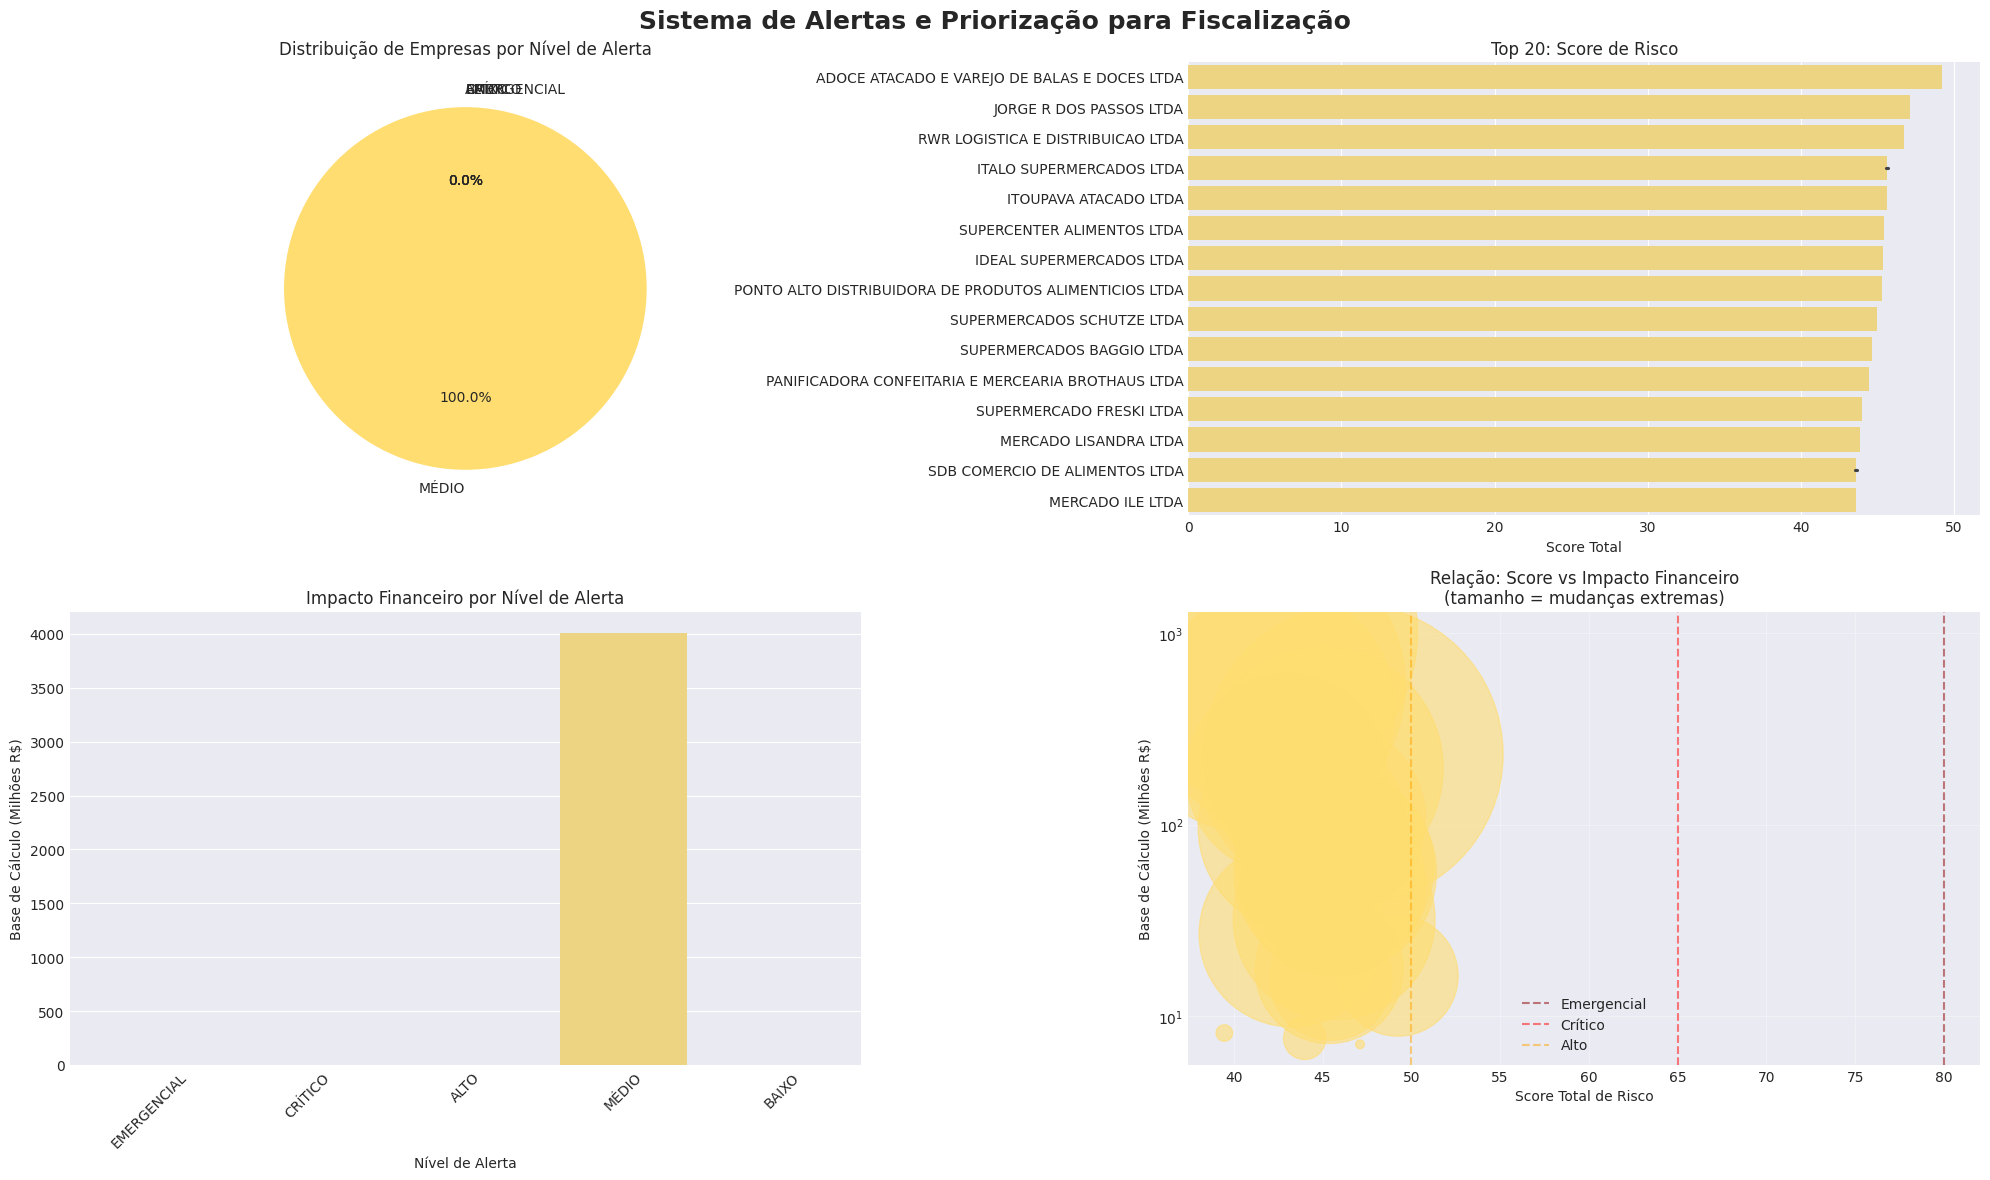

In [21]:
print("=" * 80)
print("10. SISTEMA DE ALERTAS E PRIORIZAÇÃO PARA FISCALIZAÇÃO")
print("=" * 80)

# Query de alertas
alertas_fiscalizacao = spark.sql("""
WITH empresa_scoring AS (
    SELECT 
        cnpj_emitente,
        nm_razao_social,
        COUNT(*) as total_casos,
        SUM(bc_total_periodo) as bc_total,
        
        -- Componentes do score
        AVG(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 40 
                 WHEN classificacao_mudanca = 'MUDANCA_SIGNIFICATIVA' THEN 25 
                 ELSE 10 END) as score_classificacao,
        
        AVG(CASE WHEN movimento_vs_ia = 'AFASTOU_DA_CORRETA' THEN 30
                 WHEN movimento_vs_ia = 'MANTEVE_DISTANCIA' THEN 15
                 ELSE 5 END) as score_movimento,
        
        AVG(CASE WHEN ABS(diferenca_vs_ia_periodo) >= 0.20 THEN 20
                 WHEN ABS(diferenca_vs_ia_periodo) >= 0.10 THEN 15
                 WHEN ABS(diferenca_vs_ia_periodo) >= 0.05 THEN 10
                 ELSE 5 END) as score_magnitude,
        
        -- Métricas de comportamento
        SUM(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 1 ELSE 0 END) as mudancas_extremas,
        SUM(CASE WHEN movimento_vs_ia = 'AFASTOU_DA_CORRETA' THEN 1 ELSE 0 END) as afastou_ia,
        AVG(diferenca_vs_ia_periodo) as diff_ia_media
        
    FROM dados_argos
    WHERE movimento_vs_ia != 'SEM_REFERENCIA_IA'
    GROUP BY cnpj_emitente, nm_razao_social
    HAVING COUNT(*) >= 5
)
SELECT 
    *,
    (score_classificacao + score_movimento + score_magnitude) as score_total,
    CASE 
        WHEN (score_classificacao + score_movimento + score_magnitude) >= 80 THEN 'EMERGENCIAL'
        WHEN (score_classificacao + score_movimento + score_magnitude) >= 65 THEN 'CRÍTICO'
        WHEN (score_classificacao + score_movimento + score_magnitude) >= 50 THEN 'ALTO'
        WHEN (score_classificacao + score_movimento + score_magnitude) >= 35 THEN 'MÉDIO'
        ELSE 'BAIXO'
    END as nivel_alerta
FROM empresa_scoring
ORDER BY score_total DESC, bc_total DESC
LIMIT 50
""")

alertas_pd = alertas_fiscalizacao.toPandas()
alertas_pd['bc_total'] = alertas_pd['bc_total'].astype(float)

# Distribuição de alertas
dist_alertas = alertas_pd['nivel_alerta'].value_counts()

print("\nDISTRIBUIÇÃO DE ALERTAS:")
for nivel in ['EMERGENCIAL', 'CRÍTICO', 'ALTO', 'MÉDIO', 'BAIXO']:
    if nivel in dist_alertas.index:
        qtd = dist_alertas[nivel]
        bc_nivel = alertas_pd[alertas_pd['nivel_alerta'] == nivel]['bc_total'].sum()
        print(f"  {nivel:15}: {qtd:3d} empresas | BC: R$ {bc_nivel:,.2f}")

print("\nTOP 20 EMPRESAS PRIORITÁRIAS PARA FISCALIZAÇÃO:")
for i, row in alertas_pd.head(20).iterrows():
    print(f"\n{i+1:2d}. [{row['nivel_alerta']}] {row['nm_razao_social'][:45]}")
    print(f"    Score: {row['score_total']:.1f} | BC: R$ {row['bc_total']:,.2f}")
    print(f"    Extremas: {row['mudancas_extremas']} | Afastou IA: {row['afastou_ia']}")
    print(f"    Diff IA Média: {row['diff_ia_media']*100:+.2f}%")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Sistema de Alertas e Priorização para Fiscalização', fontsize=18, fontweight='bold')

# Gráfico 1: Distribuição de alertas
cores_alerta = {'EMERGENCIAL': '#8b0000', 'CRÍTICO': '#d62728', 
                'ALTO': '#ff7f0e', 'MÉDIO': '#ffdd70', 'BAIXO': '#2ca02c'}
ordem_alerta = ['EMERGENCIAL', 'CRÍTICO', 'ALTO', 'MÉDIO', 'BAIXO']
dist_alertas_ordenado = dist_alertas.reindex(ordem_alerta, fill_value=0)
palette_alerta = [cores_alerta[x] for x in dist_alertas_ordenado.index]

axes[0,0].pie(dist_alertas_ordenado.values, labels=dist_alertas_ordenado.index, 
              autopct='%1.1f%%', colors=palette_alerta, startangle=90)
axes[0,0].set_title('Distribuição de Empresas por Nível de Alerta')

# Gráfico 2: Score total (Top 20)
top20_score = alertas_pd.head(20)
cores_empresas = [cores_alerta[x] for x in top20_score['nivel_alerta']]
sns.barplot(data=top20_score, y='nm_razao_social', x='score_total', 
            ax=axes[0,1], palette=cores_empresas, orient='h')
axes[0,1].set_title('Top 20: Score de Risco')
axes[0,1].set_xlabel('Score Total')
axes[0,1].set_ylabel('')

# Gráfico 3: Impacto financeiro por nível
bc_por_nivel = alertas_pd.groupby('nivel_alerta')['bc_total'].sum().reindex(ordem_alerta, fill_value=0)
sns.barplot(x=bc_por_nivel.index, y=bc_por_nivel.values/1e6, 
            ax=axes[1,0], palette=[cores_alerta[x] for x in bc_por_nivel.index])
axes[1,0].set_ylabel('Base de Cálculo (Milhões R$)')
axes[1,0].set_xlabel('Nível de Alerta')
axes[1,0].set_title('Impacto Financeiro por Nível de Alerta')
axes[1,0].tick_params(axis='x', rotation=45)

# Gráfico 4: Scatter - Score vs BC
cores_scatter = [cores_alerta[x] for x in alertas_pd['nivel_alerta']]
axes[1,1].scatter(alertas_pd['score_total'], alertas_pd['bc_total']/1e6, 
                  s=alertas_pd['mudancas_extremas']*10, alpha=0.6, c=cores_scatter)
axes[1,1].set_xlabel('Score Total de Risco')
axes[1,1].set_ylabel('Base de Cálculo (Milhões R$)')
axes[1,1].set_title('Relação: Score vs Impacto Financeiro\n(tamanho = mudanças extremas)')
axes[1,1].set_yscale('log')
axes[1,1].grid(True, alpha=0.3)

# Linhas de corte
axes[1,1].axvline(x=80, color='darkred', linestyle='--', alpha=0.5, label='Emergencial')
axes[1,1].axvline(x=65, color='red', linestyle='--', alpha=0.5, label='Crítico')
axes[1,1].axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='Alto')
axes[1,1].legend()

plt.tight_layout()
plt.show()

11. GERAÇÃO DE RELATÓRIO CONSOLIDADO

✅ Relatório consolidado gerado
   Total de registros: 5,252,190

RESUMO EXECUTIVO - SISTEMA ARGOS
                             Métrica            Valor
       Total de Registros Analisados        4,553,767
                Empresas Monitoradas               28
                  Produtos Distintos           73,209
                 Períodos Analisados               34
          Base de Cálculo Total (R$) 4,005,390,098.76
         Taxa de Correção Global (%)             14.1
                   Mudanças Extremas           43,342
                   Empresas Críticas                0
Impacto Arrecadatório Realizado (R$) 2,753,338,602.78
        Potencial Arrecadatório (R$) 2,017,727,516.56


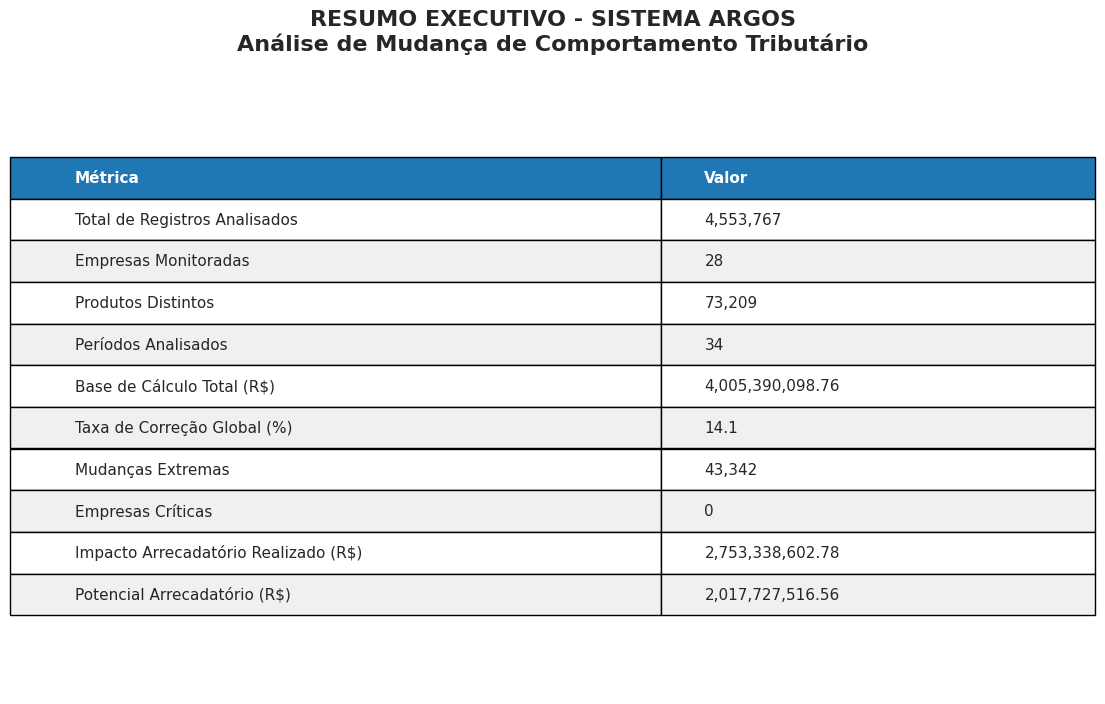


RECOMENDAÇÕES ESTRATÉGICAS:
1. AÇÃO IMEDIATA: Fiscalizar 0 empresas emergenciais
2. CURTO PRAZO: Auditar 0 empresas críticas


NameError: name 'top5_setores' is not defined

In [22]:
print("=" * 80)
print("11. GERAÇÃO DE RELATÓRIO CONSOLIDADO")
print("=" * 80)

# Criar DataFrame consolidado para exportação
relatorio_completo = spark.sql("""
SELECT 
    a.periodo,
    a.cnpj_emitente,
    a.nm_razao_social,
    a.gtin,
    a.ncm,
    a.descricao,
    ROUND(a.aliq_emitente_periodo * 100, 2) as aliquota_praticada_pct,
    ROUND(a.aliq_emitente_media_historica * 100, 2) as aliquota_historica_pct,
    ROUND(a.aliquota_ia * 100, 2) as aliquota_ia_pct,
    ROUND(a.diferenca_vs_ia_periodo * 100, 2) as diferenca_vs_ia_pct,
    a.classificacao_mudanca,
    a.movimento_vs_ia,
    a.bc_total_periodo,
    
    -- Adicionar informações de alerta se disponível
    COALESCE(al.nivel_alerta, 'NÃO AVALIADO') as nivel_alerta_empresa,
    COALESCE(al.score_total, 0) as score_risco_empresa
    
FROM dados_argos a
LEFT JOIN (
    SELECT cnpj_emitente, 
           CASE 
               WHEN AVG(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 40 ELSE 10 END) >= 30 THEN 'CRÍTICO'
               WHEN AVG(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 40 ELSE 10 END) >= 20 THEN 'ALTO'
               ELSE 'MÉDIO'
           END as nivel_alerta,
           AVG(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 40 ELSE 10 END) as score_total
    FROM dados_argos
    GROUP BY cnpj_emitente
) al ON a.cnpj_emitente = al.cnpj_emitente
ORDER BY a.cnpj_emitente, a.periodo, a.descricao
""")

# Salvar relatório (comentado - descomente para salvar)
# relatorio_completo.write.mode('overwrite').parquet('/caminho/para/salvar/relatorio_argos')

print("\n✅ Relatório consolidado gerado")
print(f"   Total de registros: {relatorio_completo.count():,}")

# Criar resumo executivo em Pandas
resumo_executivo = pd.DataFrame({
    'Métrica': [
        'Total de Registros Analisados',
        'Empresas Monitoradas',
        'Produtos Distintos',
        'Períodos Analisados',
        'Base de Cálculo Total (R$)',
        'Taxa de Correção Global (%)',
        'Mudanças Extremas',
        'Empresas Críticas',
        'Impacto Arrecadatório Realizado (R$)',
        'Potencial Arrecadatório (R$)'
    ],
    'Valor': [
        f"{kpi_data['total_registros']:,}",
        f"{kpi_data['total_empresas']:,}",
        f"{kpi_data['total_produtos']:,}",
        f"{kpi_data['total_periodos']}",
        f"{kpi_data['bc_total_sistema']:,.2f}",
        f"{taxa_correcao_global:.1f}",
        f"{kpi_data['mudancas_extremas']:,}",
        f"{dist_alertas.get('CRÍTICO', 0) + dist_alertas.get('EMERGENCIAL', 0)}",
        f"{impacto_realizado_sistema:,.2f}",
        f"{impacto_potencial_sistema:,.2f}"
    ]
})

print("\n" + "="*80)
print("RESUMO EXECUTIVO - SISTEMA ARGOS")
print("="*80)
print(resumo_executivo.to_string(index=False))

# Visualização do resumo
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('tight')
ax.axis('off')

table_data = [resumo_executivo.columns.tolist()] + resumo_executivo.values.tolist()
table = ax.table(cellText=table_data, cellLoc='left', loc='center',
                 colWidths=[0.6, 0.4])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Estilizar cabeçalho
for i in range(len(resumo_executivo.columns)):
    table[(0, i)].set_facecolor('#1f77b4')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Estilizar linhas
for i in range(1, len(table_data)):
    for j in range(len(resumo_executivo.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

plt.title('RESUMO EXECUTIVO - SISTEMA ARGOS\nAnálise de Mudança de Comportamento Tributário', 
          fontsize=16, fontweight='bold', pad=20)
plt.show()

print("\n" + "="*80)
print("RECOMENDAÇÕES ESTRATÉGICAS:")
print("="*80)
print(f"1. AÇÃO IMEDIATA: Fiscalizar {dist_alertas.get('EMERGENCIAL', 0)} empresas emergenciais")
print(f"2. CURTO PRAZO: Auditar {dist_alertas.get('CRÍTICO', 0)} empresas críticas")
print(f"3. MONITORAMENTO: Acompanhar {top5_setores['mudancas_extremas'].sum()} casos nos 5 setores mais voláteis")
print(f"4. POTENCIAL: Trabalhar para realizar R$ {impacto_potencial_sistema/1e6:.1f}M em correções")
print(f"5. DASHBOARD: Implementar monitoramento contínuo dos KPIs apresentados")

12. ANÁLISE COMPARATIVA TEMPORAL - EVOLUÇÃO DO COMPORTAMENTO



COMPARATIVO TEMPORAL:

PERÍODO INICIAL:
  Casos: 613,954 | Empresas: 21
  Taxa de Correção: 10.0%
  Taxa de Extremas: 1.1%
  Diff IA Média: -1504.52%

PERÍODO INTERMEDIÁRIO:
  Casos: 3,000,296 | Empresas: 28
  Taxa de Correção: 15.2%
  Taxa de Extremas: 0.7%
  Diff IA Média: -1500.01%

PERÍODO FINAL:
  Casos: 939,517 | Empresas: 28
  Taxa de Correção: 13.5%
  Taxa de Extremas: 1.7%
  Diff IA Média: -1490.36%

📊 EVOLUÇÃO DO SISTEMA:
  Variação Taxa Correção: +3.6 pontos percentuais
  Variação Taxa Extremas: +0.6 pontos percentuais
  ✅ RESULTADO POSITIVO: Aumento na taxa de correção


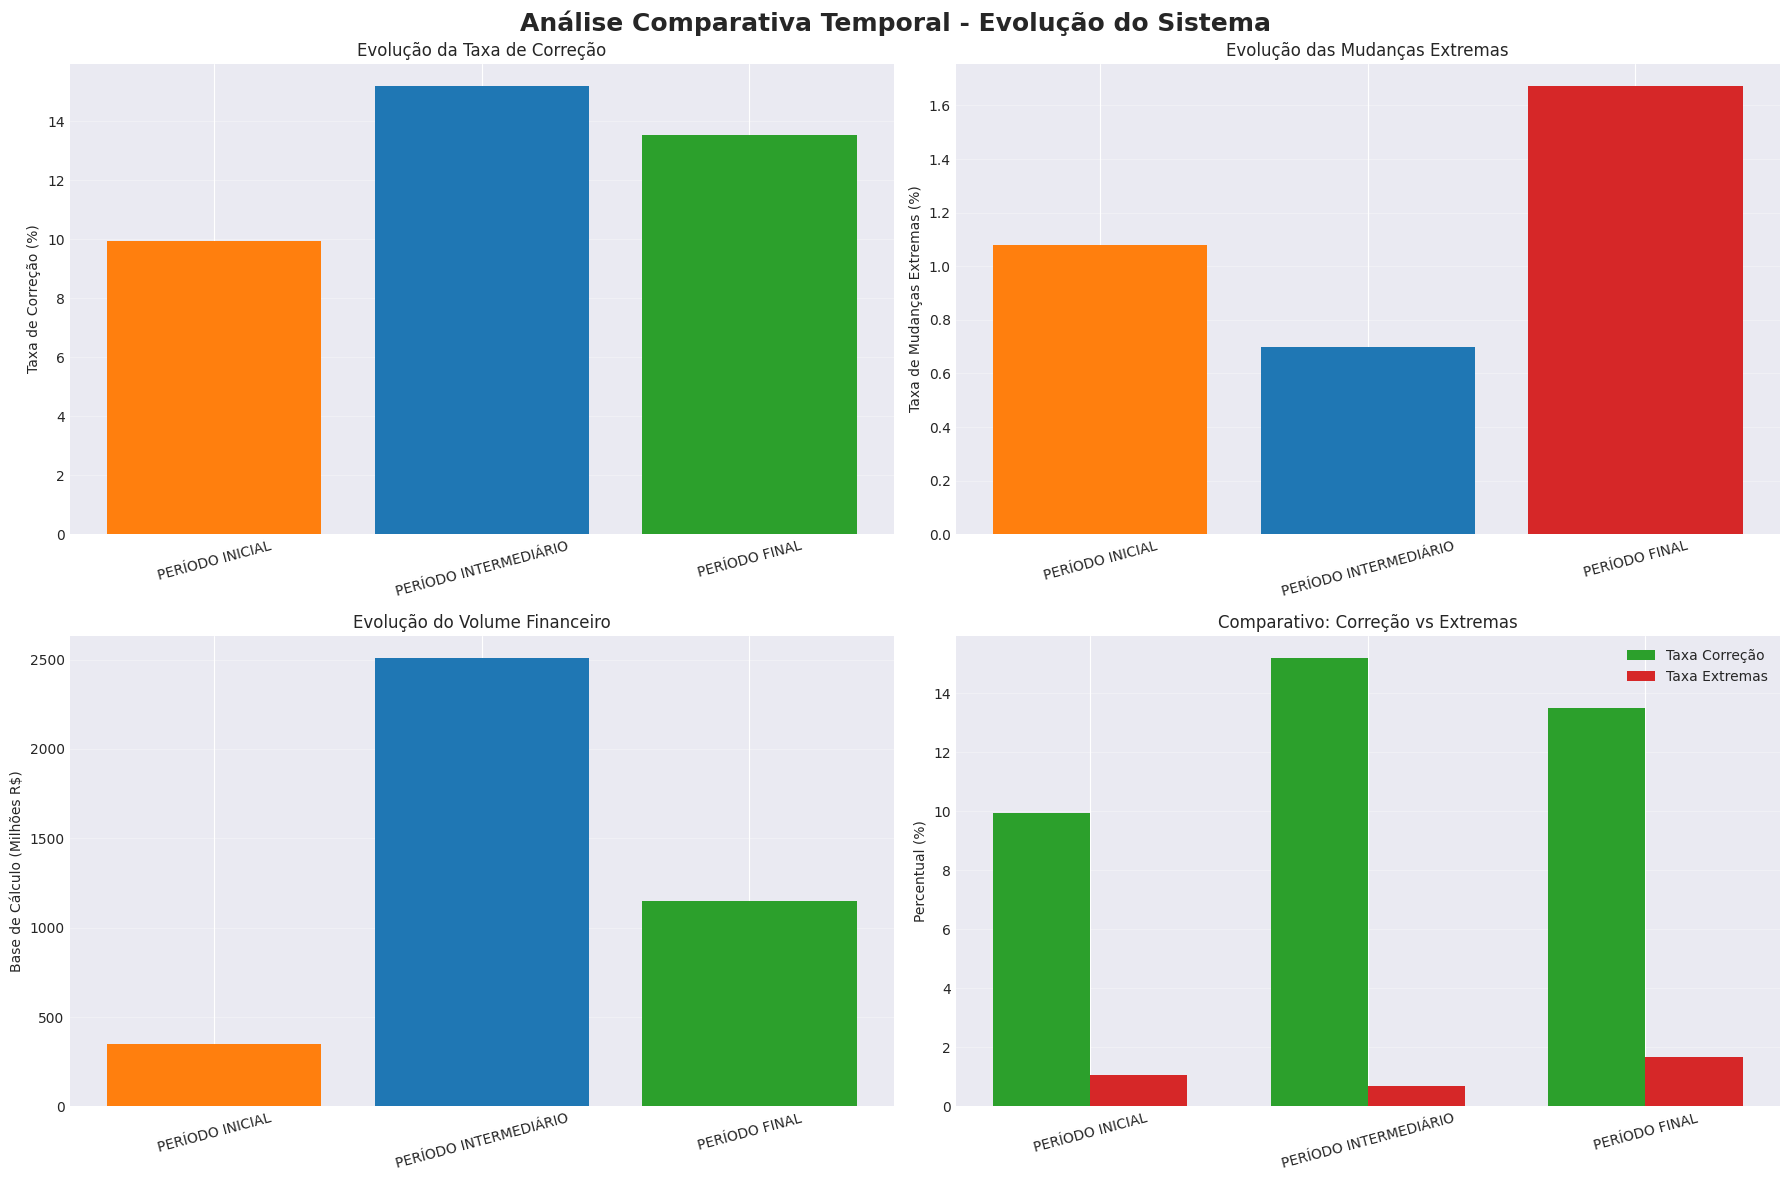

In [23]:
print("=" * 80)
print("12. ANÁLISE COMPARATIVA TEMPORAL - EVOLUÇÃO DO COMPORTAMENTO")
print("=" * 80)

# Versão simplificada sem CTEs complexas
comparativo_temporal = spark.sql("""
WITH periodos_ordenados AS (
    SELECT DISTINCT periodo
    FROM niat.argos_mudanca_comportamento
    WHERE periodo >= '202301'
    ORDER BY periodo
),
primeiros_6 AS (
    SELECT periodo FROM periodos_ordenados LIMIT 6
),
ultimos_6 AS (
    SELECT periodo FROM periodos_ordenados ORDER BY periodo DESC LIMIT 6
)
SELECT 
    CASE 
        WHEN periodo IN (SELECT periodo FROM primeiros_6) THEN 'PERÍODO INICIAL'
        WHEN periodo IN (SELECT periodo FROM ultimos_6) THEN 'PERÍODO FINAL'
        ELSE 'PERÍODO INTERMEDIÁRIO'
    END as fase,
    
    COUNT(*) as total_casos,
    COUNT(DISTINCT cnpj_emitente) as empresas,
    SUM(bc_total_periodo) as bc_total,
    AVG(diferenca_vs_ia_periodo) as diff_ia_media,
    
    SUM(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 1 ELSE 0 END) as mudancas_extremas,
    AVG(CASE WHEN classificacao_mudanca = 'MUDANCA_EXTREMA' THEN 100.0 ELSE 0.0 END) as taxa_extremas,
    
    SUM(CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' THEN 1 ELSE 0 END) as aproximou_ia,
    AVG(CASE WHEN movimento_vs_ia = 'APROXIMOU_DA_CORRETA' THEN 100.0 ELSE 0.0 END) as taxa_correcao

FROM niat.argos_mudanca_comportamento
WHERE movimento_vs_ia != 'SEM_REFERENCIA_IA'
  AND periodo >= '202301'
GROUP BY fase
ORDER BY 
    CASE fase
        WHEN 'PERÍODO INICIAL' THEN 1
        WHEN 'PERÍODO INTERMEDIÁRIO' THEN 2
        ELSE 3
    END
""")

comp_pd = comparativo_temporal.toPandas()
comp_pd['bc_total'] = pd.to_numeric(comp_pd['bc_total'], errors='coerce')
comp_pd['diff_ia_media'] = pd.to_numeric(comp_pd['diff_ia_media'], errors='coerce')

print("\nCOMPARATIVO TEMPORAL:")
for _, row in comp_pd.iterrows():
    print(f"\n{row['fase']}:")
    print(f"  Casos: {row['total_casos']:,} | Empresas: {int(row['empresas']):,}")
    print(f"  Taxa de Correção: {row['taxa_correcao']:.1f}%")
    print(f"  Taxa de Extremas: {row['taxa_extremas']:.1f}%")
    print(f"  Diff IA Média: {row['diff_ia_media']*100:+.2f}%")


# Calcular evolução
if len(comp_pd) >= 2:
    inicial = comp_pd[comp_pd['fase'] == 'PERÍODO INICIAL'].iloc[0]
    final = comp_pd[comp_pd['fase'] == 'PERÍODO FINAL'].iloc[0]
    
    evolucao_correcao = final['taxa_correcao'] - inicial['taxa_correcao']
    evolucao_extremas = final['taxa_extremas'] - inicial['taxa_extremas']
    
    print(f"\n📊 EVOLUÇÃO DO SISTEMA:")
    print(f"  Variação Taxa Correção: {evolucao_correcao:+.1f} pontos percentuais")
    print(f"  Variação Taxa Extremas: {evolucao_extremas:+.1f} pontos percentuais")
    
    if evolucao_correcao > 0:
        print(f"  ✅ RESULTADO POSITIVO: Aumento na taxa de correção")
    else:
        print(f"  ⚠️ ATENÇÃO: Redução na taxa de correção")

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Análise Comparativa Temporal - Evolução do Sistema', fontsize=18, fontweight='bold')

# Gráfico 1: Taxa de correção
axes[0,0].bar(comp_pd['fase'], comp_pd['taxa_correcao'], color=['#ff7f0e', '#1f77b4', '#2ca02c'])
axes[0,0].set_ylabel('Taxa de Correção (%)')
axes[0,0].set_title('Evolução da Taxa de Correção')
axes[0,0].tick_params(axis='x', rotation=15)
axes[0,0].grid(True, alpha=0.3, axis='y')

# Gráfico 2: Taxa de extremas
axes[0,1].bar(comp_pd['fase'], comp_pd['taxa_extremas'], color=['#ff7f0e', '#1f77b4', '#d62728'])
axes[0,1].set_ylabel('Taxa de Mudanças Extremas (%)')
axes[0,1].set_title('Evolução das Mudanças Extremas')
axes[0,1].tick_params(axis='x', rotation=15)
axes[0,1].grid(True, alpha=0.3, axis='y')

# Gráfico 3: Base de cálculo
axes[1,0].bar(comp_pd['fase'], comp_pd['bc_total']/1e6, color=['#ff7f0e', '#1f77b4', '#2ca02c'])
axes[1,0].set_ylabel('Base de Cálculo (Milhões R$)')
axes[1,0].set_title('Evolução do Volume Financeiro')
axes[1,0].tick_params(axis='x', rotation=15)
axes[1,0].grid(True, alpha=0.3, axis='y')

# Gráfico 4: Comparativo dual
x = np.arange(len(comp_pd))
width = 0.35
axes[1,1].bar(x - width/2, comp_pd['taxa_correcao'], width, label='Taxa Correção', color='#2ca02c')
axes[1,1].bar(x + width/2, comp_pd['taxa_extremas'], width, label='Taxa Extremas', color='#d62728')
axes[1,1].set_ylabel('Percentual (%)')
axes[1,1].set_title('Comparativo: Correção vs Extremas')
axes[1,1].set_xticks(x)
axes[1,1].set_xticklabels(comp_pd['fase'], rotation=15)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [24]:
print("=" * 80)
print("FINALIZAÇÃO DA ANÁLISE")
print("=" * 80)

# Estatísticas de processamento
tempo_total = datetime.now()
print(f"\n✅ Análise concluída com sucesso!")
print(f"   Data/Hora: {tempo_total.strftime('%Y-%m-%d %H:%M:%S')}")

# Liberar cache
df_argos.unpersist()

print("\n📊 VIEWS SPARK DISPONÍVEIS:")
print("   • dados_argos - Dados principais")
print("   • relatorio_completo - Relatório consolidado")

print("\n💾 DATAFRAMES PANDAS DISPONÍVEIS:")
print("   • dist_class_pd - Distribuição por classificação")
print("   • dist_mov_pd - Distribuição por movimento")
print("   • evolucao_pd - Evolução temporal")
print("   • ranking_pd - Ranking de empresas")
print("   • setorial_pd - Análise setorial")
print("   • produtos_pd - Produtos voláteis")
print("   • impacto_pd - Impacto arrecadatório")
print("   • alertas_pd - Sistema de alertas")
print("   • resumo_executivo - Resumo executivo")

print("\n🎯 PRÓXIMOS PASSOS RECOMENDADOS:")
print("   1. Exportar dados para dashboard de monitoramento")
print("   2. Iniciar fiscalização das empresas emergenciais")
print("   3. Agendar auditorias das empresas críticas")
print("   4. Implementar alertas automáticos por período")
print("   5. Criar relatórios mensais de acompanhamento")

print("\n" + "="*80)
print("SISTEMA ARGOS - ANÁLISE COMPLETA FINALIZADA")
print("="*80)

FINALIZAÇÃO DA ANÁLISE

✅ Análise concluída com sucesso!
   Data/Hora: 2025-10-03 15:17:13

📊 VIEWS SPARK DISPONÍVEIS:
   • dados_argos - Dados principais
   • relatorio_completo - Relatório consolidado

💾 DATAFRAMES PANDAS DISPONÍVEIS:
   • dist_class_pd - Distribuição por classificação
   • dist_mov_pd - Distribuição por movimento
   • evolucao_pd - Evolução temporal
   • ranking_pd - Ranking de empresas
   • setorial_pd - Análise setorial
   • produtos_pd - Produtos voláteis
   • impacto_pd - Impacto arrecadatório
   • alertas_pd - Sistema de alertas
   • resumo_executivo - Resumo executivo

🎯 PRÓXIMOS PASSOS RECOMENDADOS:
   1. Exportar dados para dashboard de monitoramento
   2. Iniciar fiscalização das empresas emergenciais
   3. Agendar auditorias das empresas críticas
   4. Implementar alertas automáticos por período
   5. Criar relatórios mensais de acompanhamento

SISTEMA ARGOS - ANÁLISE COMPLETA FINALIZADA
